In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df = pd.read_excel("../DATA/DataHackathon.xlsx")

df = df[df['Cantidad'] != 0]
print((df['Cantidad'] == 0).sum())  

mask_unidades = df['Unidad de venta'].isin(['KG', 'L'])
mask_tres_ceros = df['Cantidad'] % 1000 == 0
mask_conversion = mask_unidades & mask_tres_ceros
df.loc[mask_conversion, 'Cantidad'] = df.loc[mask_conversion, 'Cantidad'] / 1000

df[mask_conversion][['Cantidad', 'Unidad de venta']]

0


Cantidad Unidad de venta
25            6              KG
194          54              KG
221           3              KG
222           3              KG
405           9              KG
...         ...             ...
30332         9               L
30558         3              KG
30655         3              KG
31084         3               L
31085         3               L

[187 rows x 2 columns]

### Preparación

In [3]:
df['Fecha'] = pd.to_datetime(df['Creacion Orden de Venta'])
df['Día'] = df['Fecha']
df['Año'] = df['Fecha'].dt.year
df['Mes'] = df['Fecha'].dt.month
df['Semana'] = df['Fecha'].dt.isocalendar().week
df['Trimestre'] = df['Fecha'].dt.quarter
df['Semestre'] = df['Mes'].apply(lambda x: 1 if x <=6 else 2)

### Agregar Ventas Temporales

In [4]:
ventas_diarias = df.groupby(['Año', 'Día'])['Cantidad'].sum().reset_index()
ventas_semanal = df.groupby(['Año', 'Semana'])['Cantidad'].sum().reset_index()
ventas_mensual = df.groupby(['Año', 'Mes'])['Cantidad'].sum().reset_index()
ventas_trimestral = df.groupby(['Año', 'Trimestre'])['Cantidad'].sum().reset_index()
ventas_semestral = df.groupby(['Año', 'Semestre'])['Cantidad'].sum().reset_index()
ventas_anual = df.groupby(['Año'])['Cantidad'].sum().reset_index()

ventas_semanal.columns

Index(['Año', 'Semana', 'Cantidad'], dtype='object')

### Visualización de Ventas por Periodo

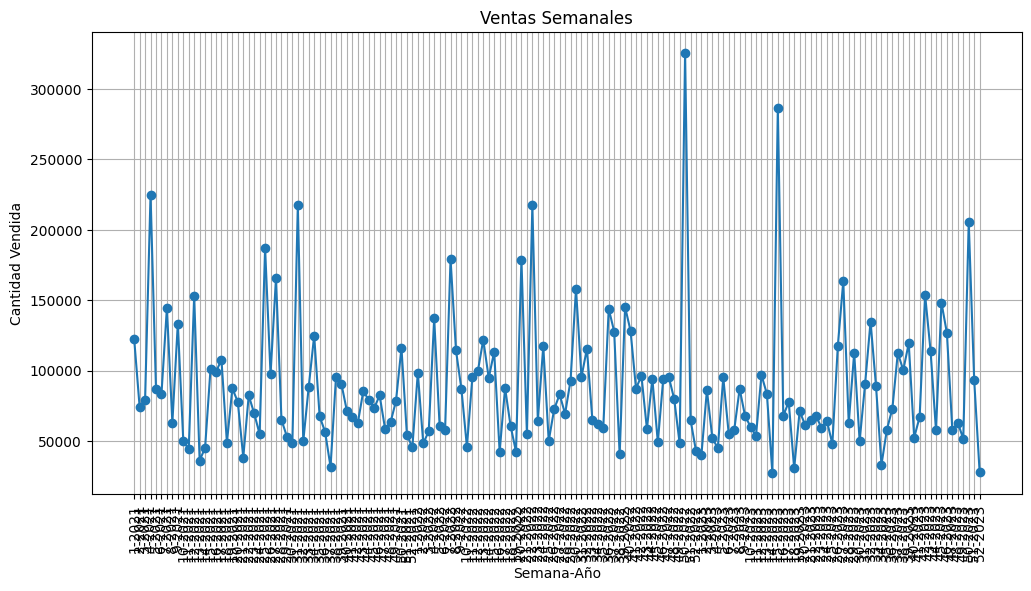

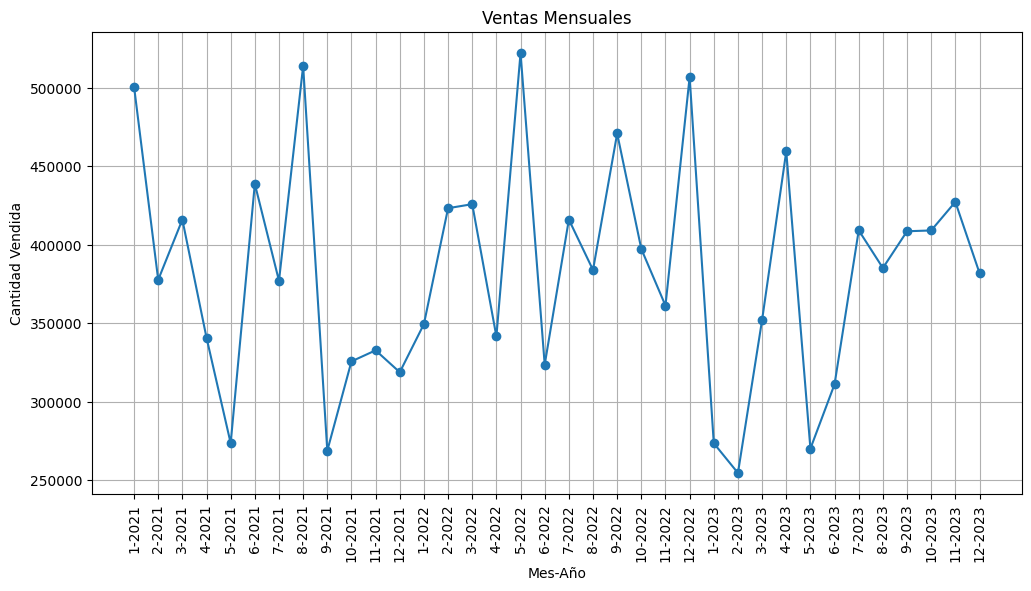

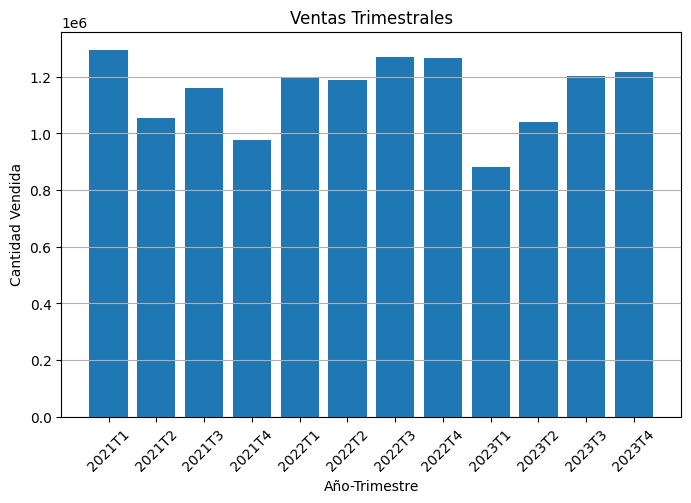

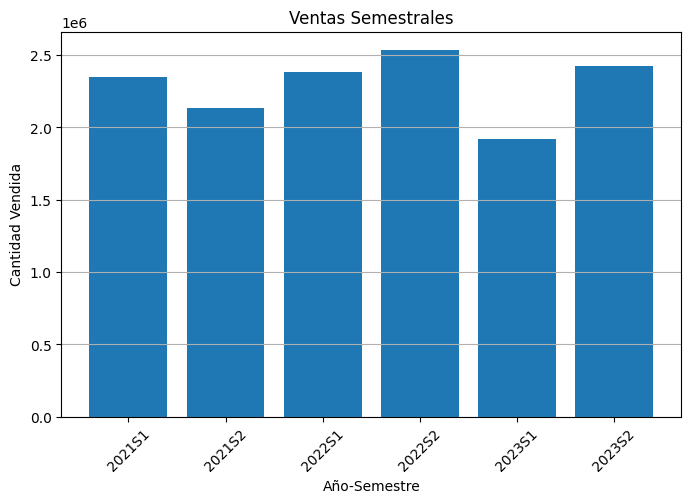

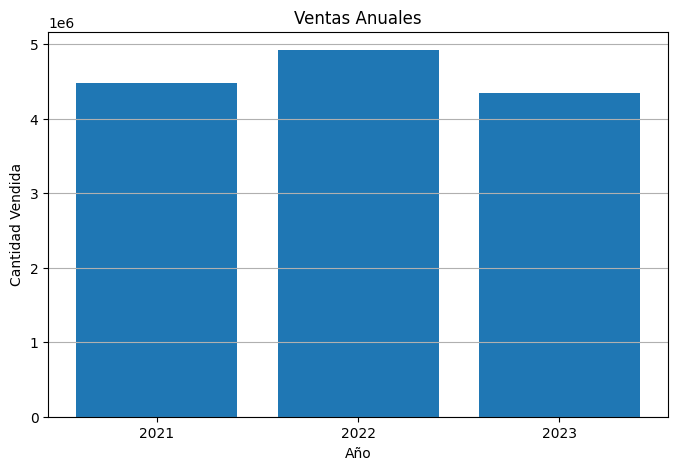

In [5]:
plt.figure(figsize=(12,6))
plt.plot(ventas_semanal['Semana'].astype(str) + '-' + ventas_semanal['Año'].astype(str), ventas_semanal['Cantidad'], marker='o')
plt.xticks(rotation=90)
plt.title('Ventas Semanales')
plt.xlabel('Semana-Año')
plt.ylabel('Cantidad Vendida')
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(ventas_mensual['Mes'].astype(str) + '-' + ventas_mensual['Año'].astype(str), ventas_mensual['Cantidad'], marker='o')
plt.xticks(rotation=90)
plt.title('Ventas Mensuales')
plt.xlabel('Mes-Año')
plt.ylabel('Cantidad Vendida')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(ventas_trimestral['Año'].astype(str) + 'T' + ventas_trimestral['Trimestre'].astype(str), ventas_trimestral['Cantidad'])
plt.title('Ventas Trimestrales')
plt.xlabel('Año-Trimestre')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(8,5))
plt.bar(ventas_semestral['Año'].astype(str) + 'S' + ventas_semestral['Semestre'].astype(str), ventas_semestral['Cantidad'])
plt.title('Ventas Semestrales')
plt.xlabel('Año-Semestre')
plt.ylabel('Cantidad Vendida')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(8,5))
plt.bar(ventas_anual['Año'].astype(str), ventas_anual['Cantidad'])
plt.title('Ventas Anuales')
plt.xlabel('Año')
plt.ylabel('Cantidad Vendida')
plt.grid(axis='y')
plt.show()


### Decomposición Temporal (Estacionalidades y Tendencias Globales en las Ventas)

In [6]:
ventas_mensual['Fecha'] = pd.to_datetime(ventas_mensual['Año'].astype(str) + '-' + ventas_mensual['Mes'].astype(str) + '-01')
ventas_mensual.set_index('Fecha', inplace=True)

result = seasonal_decompose(ventas_mensual['Cantidad'], model='additive', period=12)

<Figure size 1200x800 with 0 Axes>

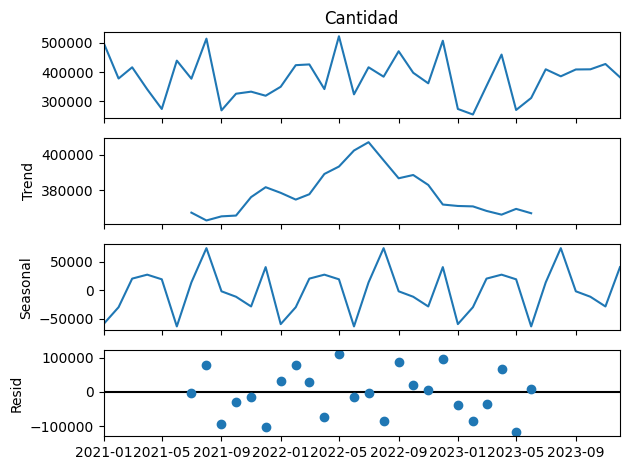

In [7]:
plt.figure(figsize=(12,8))
result.plot()
plt.show()

### Fuerza Estacional Mensual

In [8]:
# Usamos los resultados de la descomposición que ya tenías
observed = result.observed.dropna()     # Serie original
trend = result.trend.dropna()           # Tendencia
seasonal = result.seasonal.dropna()     # Estacionalidad
resid = result.resid.dropna()           # Residuos

# Alineamos las series para que tengan el mismo tamaño (descomposición corta los bordes)
aligned_index = observed.index.intersection(trend.index).intersection(seasonal.index).intersection(resid.index)

observed = observed.loc[aligned_index]
trend = trend.loc[aligned_index]
seasonal = seasonal.loc[aligned_index]
resid = resid.loc[aligned_index]

# Varianzas
var_resid = np.var(resid)
var_observed = np.var(observed)
var_trend = np.var(trend)
var_seasonal = np.var(seasonal)

# Fuerza de la estacionalidad
seasonality_strength = 1 - (var_resid / (var_observed - var_trend))

# Fuerza de la tendencia
trend_strength = 1 - (var_resid / (var_observed - var_seasonal))

# Mostramos los resultados
print(f'Fuerza de la Estacionalidad: {seasonality_strength:.2f}')
print(f'Fuerza de la Tendencia: {trend_strength:.2f}')

Fuerza de la Estacionalidad: 0.26
Fuerza de la Tendencia: 0.04


### Interpretación de la Fuerza de Estacionalidad y Tendencia (Mensual)

En esta sección se calcularon las métricas de **fuerza de estacionalidad** y **fuerza de tendencia** a partir de la descomposición de la serie temporal de ventas mensuales agregadas.

- **Fuerza de la Estacionalidad**: 0.26  
  Este valor indica que la estacionalidad explica aproximadamente el 26% de la variabilidad en la serie de ventas mensuales. La estacionalidad es considerada **débil**, lo que significa que los patrones recurrentes a lo largo del año no son consistentes o predominantes en los datos.

- **Fuerza de la Tendencia**: 0.04  
  Este valor muestra que la tendencia explica apenas el 4% de la variabilidad total. Esto implica que no existe una tendencia clara de crecimiento o decrecimiento en las ventas durante el período analizado. La serie presenta un comportamiento más estacionario en términos de tendencia.

#### Conclusiones sobre el análisis
El bajo nivel de estacionalidad y la ausencia de una tendencia marcada sugieren que las ventas mensuales, en conjunto, no presentan un patrón temporal fuerte que pueda ser predecible.

### Fuerza Estacional Semanal

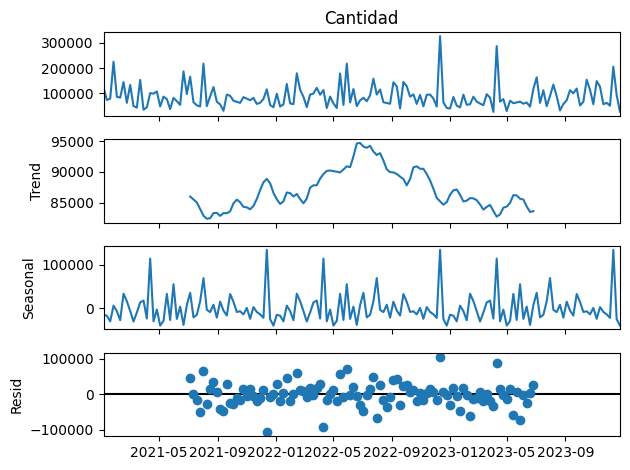

Fuerza de la Estacionalidad: 0.51
Fuerza de la Tendencia: 0.01


In [9]:
ventas_semanal['Fecha'] = ventas_semanal['Año'].astype(str) + '-' + ventas_semanal['Semana'].astype(str) + '-1'
ventas_semanal['Fecha'] = pd.to_datetime(ventas_semanal['Fecha'], format='%Y-%W-%w')

ventas_semanal.set_index('Fecha', inplace=True)

result_semanal = seasonal_decompose(ventas_semanal['Cantidad'], model='additive', period=52)

result_semanal.plot()
plt.show()


observed = result_semanal.observed.dropna()    
trend = result_semanal.trend.dropna()           
seasonal = result_semanal.seasonal.dropna()   
resid = result_semanal.resid.dropna()          


aligned_index = observed.index.intersection(trend.index).intersection(seasonal.index).intersection(resid.index)

observed = observed.loc[aligned_index]
trend = trend.loc[aligned_index]
seasonal = seasonal.loc[aligned_index]
resid = resid.loc[aligned_index]

# Varianzas
var_resid = np.var(resid)
var_observed = np.var(observed)
var_trend = np.var(trend)
var_seasonal = np.var(seasonal)

seasonality_strength = 1 - (var_resid / (var_observed - var_trend))

trend_strength = 1 - (var_resid / (var_observed - var_seasonal))

print(f'Fuerza de la Estacionalidad: {seasonality_strength:.2f}')
print(f'Fuerza de la Tendencia: {trend_strength:.2f}')

### Interpretación de la Fuerza de Estacionalidad y Tendencia (Semanal)

En este análisis, revisamos cómo se comportan las ventas a lo largo del tiempo, específicamente por semana. Lo que buscamos es entender si hay patrones repetitivos (estacionalidad) o si la demanda va creciendo o disminuyendo de manera sostenida (tendencia).

### Resultados:
Fuerza de la Estacionalidad: 0.51
Esto significa que cerca del 51% de los cambios en las ventas semanales se pueden explicar por patrones que se repiten cada año. En otras palabras, hay semanas en las que es común que las ventas suban o bajen, y eso ocurre de forma relativamente consistente. Esto es importante porque nos permite anticipar esos cambios y prepararnos mejor.
Fuerza de la Tendencia: 0.01
Aquí vemos que solo el 1% del comportamiento de las ventas tiene que ver con una tendencia general a subir o bajar con el tiempo. Esto quiere decir que no estamos viendo un crecimiento sostenido en la demanda, ni una caída. Las ventas se mantienen estables, sin una dirección clara.

### ¿Qué significa esto para nosotros?
Hay un patrón semanal que se repite y que podemos aprovechar. Si sabemos que ciertas semanas las ventas suelen subir o bajar, podemos preparar el inventario en consecuencia.
Como no hay una tendencia clara hacia el crecimiento o la disminución de la demanda, es poco probable que necesitemos hacer ajustes grandes a largo plazo. Lo importante será enfocarnos en los ciclos semanales.

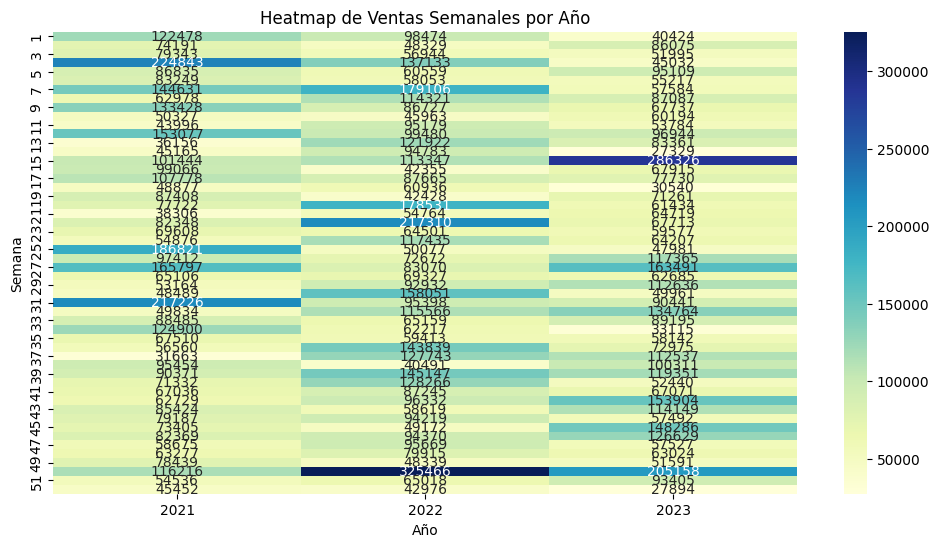

In [10]:
pivot = ventas_semanal.pivot_table(values='Cantidad', index='Semana', columns='Año', aggfunc='sum')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Heatmap de Ventas Semanales por Año')
plt.xlabel('Año')
plt.ylabel('Semana')
plt.show()

### Estas son las ventas por semana de cada año 

### Estacionalidad y Tendencias por Producto

#### Vamos a investigar ccon cuántos productos podemos cubrir gran parte de la demanda:

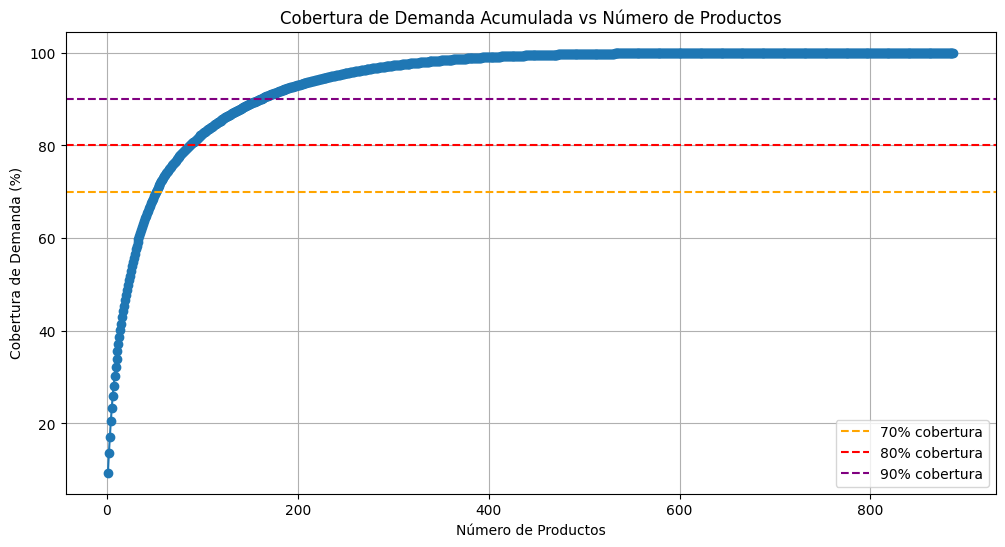

 Para cubrir el 70% de la demanda necesitas 52 productos.
 Para cubrir el 80% de la demanda necesitas 87 productos.
 Para cubrir el 90% de la demanda necesitas 161 productos.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que ya tienes el DataFrame de volumen total vendido por producto
# Si no, créalo de nuevo aquí:
ventas_por_producto = df.groupby('Articulo')['Cantidad'].sum().reset_index()
ventas_por_producto = ventas_por_producto.rename(columns={'Cantidad': 'Volumen_Vendido'})


total_ventas = ventas_por_producto['Volumen_Vendido'].sum()


ventas_por_producto = ventas_por_producto.sort_values(by='Volumen_Vendido', ascending=False).reset_index(drop=True)


ventas_por_producto['Volumen_Acumulado'] = ventas_por_producto['Volumen_Vendido'].cumsum()


ventas_por_producto['Cobertura_Demanda_%'] = ventas_por_producto['Volumen_Acumulado'] / total_ventas * 100

plt.figure(figsize=(12,6))
plt.plot(range(1, len(ventas_por_producto)+1), ventas_por_producto['Cobertura_Demanda_%'], marker='o')
plt.axhline(70, color='orange', linestyle='--', label='70% cobertura')
plt.axhline(80, color='red', linestyle='--', label='80% cobertura')
plt.axhline(90, color='purple', linestyle='--', label='90% cobertura')

plt.title('Cobertura de Demanda Acumulada vs Número de Productos')
plt.xlabel('Número de Productos')
plt.ylabel('Cobertura de Demanda (%)')
plt.grid(True)
plt.legend()
plt.show()


for umbral in [70, 80, 90]:
    productos_necesarios = ventas_por_producto[ventas_por_producto['Cobertura_Demanda_%'] >= umbral].index.min() + 1
    print(f' Para cubrir el {umbral}% de la demanda necesitas {productos_necesarios} productos.')

#### ¿Qué significa esto?
La mayoría de la demanda se concentra en un número reducido de productos. Esto es una característica común en muchos negocios, donde un grupo pequeño de productos (el famoso principio de Pareto o regla 80/20) genera la mayor parte de las ventas.
Focalizar los modelos de predicción y el control de inventario en los primeros 87 productos (por ejemplo, aquellos que cubren el 80% de la demanda) puede ser una estrategia eficiente. Esto permite priorizar recursos y maximizar el impacto en el negocio sin necesidad de modelar absolutamente todos los productos.

In [17]:
ventas_semanal_producto = df.groupby(['Articulo', 'Año', 'Semana'])['Cantidad'].sum().reset_index()

ventas_semanal_producto['Fecha'] = pd.to_datetime(
    ventas_semanal_producto['Año'].astype(str) + '-' + ventas_semanal_producto['Semana'].astype(str) + '-1',
    format='%Y-%W-%w'
)

# 3. Top N productos por ventas totales
top_n = 88  
top_productos_semanal = (
    df.groupby('Articulo')['Cantidad'].sum()
    .sort_values(ascending=False)
    .head(top_n)
    .index.tolist()
)

print(f"Top {top_n} productos seleccionados:", top_productos_semanal)

resultados_top_productos_semanal = []

for producto in top_productos_semanal:
    data = ventas_semanal_producto[ventas_semanal_producto['Articulo'] == producto]

    serie = data.set_index('Fecha')['Cantidad'].resample('W').sum().fillna(0)
    
    if len(serie) >= 52:
        try:
            period = 52 if len(serie) >= 104 else 26

            result = seasonal_decompose(serie, model='additive', period=period)

            observed = result.observed.dropna()
            trend = result.trend.dropna()
            seasonal = result.seasonal.dropna()
            resid = result.resid.dropna()

            aligned_index = observed.index.intersection(trend.index).intersection(seasonal.index).intersection(resid.index)

            observed = observed.loc[aligned_index]
            trend = trend.loc[aligned_index]
            seasonal = seasonal.loc[aligned_index]
            resid = resid.loc[aligned_index]

            var_resid = np.var(resid)
            var_observed = np.var(observed)
            var_trend = np.var(trend)
            var_seasonal = np.var(seasonal)

            ##  CONTROLAMOS LOS DENOMINADORES
            denom_estacionalidad = var_observed - var_trend
            denom_tendencia = var_observed - var_seasonal

            # Validamos que el denominador no sea negativo o cero
            if denom_estacionalidad <= 0:
                seasonality_strength = 0
            else:
                seasonality_strength = 1 - (var_resid / denom_estacionalidad)
                seasonality_strength = min(seasonality_strength, 1)  # Limita a 1 si por redondeo se pasa

            if denom_tendencia <= 0:
                trend_strength = 0
            else:
                trend_strength = 1 - (var_resid / denom_tendencia)
                trend_strength = min(trend_strength, 1)

            print(f"Producto: {producto}")
            print(f"Estacionalidad: {round(seasonality_strength, 2)} | Tendencia: {round(trend_strength, 2)}")

            resultados_top_productos_semanal.append({
                'Producto': producto,
                'Semanas_Analizadas': len(serie),
                'Periodo_Evaluado': period,
                'Fuerza_Estacionalidad': round(seasonality_strength, 2),
                'Fuerza_Tendencia': round(trend_strength, 2)
            })

        except Exception as e:
            print(f"Error al analizar el producto {producto}: {e}")
    else:
        print(f"Producto {producto} no tiene suficientes semanas ({len(serie)}) para análisis.")
# 5. DataFrame con resultados de los top N productos SEMANALES
df_resultados_top_semanal = pd.DataFrame(resultados_top_productos_semanal)

# 6. Mostrar ranking de estacionalidad semanal
print("\n Ranking de productos por fuerza de estacionalidad (Semanal):\n")
df_resultados_top_semanal.sort_values(by='Fuerza_Estacionalidad', ascending=False)
#productos = df_resultados_top_semanal['Producto']
#productos.to_csv('productos.csv', index=False)

Top 88 productos seleccionados: ['IVP07099', 'IVP07094', 'IVP09009', 'IVP15060', 'IVP07452', 'IVP07384', 'IVP07131', 'IVP07370', 'IVP07145', 'IVP07294', 'IVP11144', 'IVP11586', 'IVP07293', 'IVP15246', 'IVP07243', 'IVP11136', 'IVP07191', 'IVP07331', 'IVP10025', 'IVP07207', 'IVP07085', 'IVP07446', 'IVP07383', 'IVP11617', 'IVP07264', 'IVP07157', 'IVP07169', 'IVP11162', 'IVP11595', 'IVP09028', 'IVP11576', 'IVP11479', 'IVP15248', 'IVP07304', 'IVP07445', 'IVP11159', 'IVP07480', 'IVP15034', 'IVP11346', 'IVP07436', 'IVP01021', 'IVP11588', 'IVP07341', 'IVP10009', 'IVP07306', 'IVP07165', 'IVP11633', 'IVP11515', 'IVP11060', 'IVP09076', 'IVP09035', 'IVP07159', 'IVP07410', 'IVP07130', 'IVP15062', 'IVP07229', 'IVP11519', 'IVP13011', 'IVP11065', 'IVP11539', 'IVP11375', 'IVP11068', 'IVP07201', 'IVP11280', 'IVP07412', 'IVP11057', 'IVP04039', 'IVP15042', 'IVP11253', 'IVP11080', 'IVP15237', 'IVP11282', 'IVP07378', 'IVP11055', 'IVP07525', 'IVP07499', 'IVP08017', 'IVP11137', 'IVP07258', 'IVP11158', 'IVP040

Producto  Semanas_Analizadas  Periodo_Evaluado  Fuerza_Estacionalidad  \
32  IVP15248                  53                26                   1.00   
40  IVP01021                  52                26                   1.00   
13  IVP15246                  54                26                   0.99   
72  IVP07378                 139                52                   0.90   
58  IVP11065                 135                52                   0.87   
..       ...                 ...               ...                    ...   
2   IVP09009                 156                52                   0.42   
8   IVP07145                 156                52                   0.41   
78  IVP11158                 154                52                   0.39   
54  IVP15062                 121                52                   0.00   
80  IVP01015                  58                26                   0.00   

    Fuerza_Tendencia  
32              0.90  
40              1.00  
13              0.81  
72              0.25  
58              0.02  
..               ...  
2              -0.01  
8              -0.02  
78              0.01  
54              0.00  
80              0.00  

[87 rows x 5 columns]

### Interpretación de la Estacionalidad y Tendencia de los Productos (Análisis Semanal)

En este análisis seleccionamos los 87 productos que representan el 80% de la demanda total. Evaluamos su comportamiento de ventas semana a semana, buscando patrones repetitivos (estacionalidad) y tendencias claras de crecimiento o disminución.
#### Fuerza de la Estacionalidad:
Algunos productos presentan un valor cercano a 1.0, lo que indica que sus ventas siguen patrones cíclicos muy marcados. Esto significa que sus ventas suben y bajan en periodos regulares, lo que facilita prever su comportamiento futuro.
#### Fuerza de la Tendencia:
Cuando este valor es alto (ejemplo, 1.0), significa que el producto muestra una tendencia sostenida, ya sea de crecimiento o decrecimiento. Es decir, las ventas no fluctúan de manera aleatoria, sino que siguen una dirección clara en el tiempo.

¿Qué nos dice esto?

Los productos con alta estacionalidad y tendencia clara son excelentes candidatos para modelos predictivos, ya que sus comportamientos son consistentes y, por tanto, más predecibles.

In [31]:
# 1. Primero agrupamos las ventas totales por producto
ventas_totales = df.groupby('Articulo')['Cantidad'].sum().reset_index()
ventas_totales.columns = ['Producto', 'Ventas_Totales']

# 2. Si ya tienes el DataFrame de fuerzas, lo usas. Ejemplo:
# df_resultados_top → viene de tu análisis semanal o mensual

df_prioridad = df_resultados_top_semanal.merge(ventas_totales, on='Producto', how='left')

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_prioridad[['Fuerza_Estacionalidad_Scaled', 'Fuerza_Tendencia_Scaled', 'Ventas_Totales_Scaled']] = scaler.fit_transform(
    df_prioridad[['Fuerza_Estacionalidad', 'Fuerza_Tendencia', 'Ventas_Totales']]
)

df_prioridad['Score_Prioridad'] = (
    df_prioridad['Fuerza_Estacionalidad_Scaled'] * 0.5 +
    df_prioridad['Fuerza_Tendencia_Scaled'] * 0.3 +
    df_prioridad['Ventas_Totales_Scaled'] * 0.2
)


df_prioridad = df_prioridad.sort_values(by='Score_Prioridad', ascending=False)

print(" Ranking de Prioridad de Productos para Predicción:\n")
df_prioridad[['Producto', 'Score_Prioridad', 'Fuerza_Estacionalidad', 'Fuerza_Tendencia', 'Ventas_Totales']].head(88)



 Ranking de Prioridad de Productos para Predicción:



Producto  Score_Prioridad  Fuerza_Estacionalidad  Fuerza_Tendencia  \
40  IVP01021         0.808054                   1.00              1.00   
32  IVP15248         0.784400                   1.00              0.90   
13  IVP15246         0.770538                   0.99              0.81   
72  IVP07378         0.542512                   0.90              0.25   
0   IVP07099         0.505556                   0.55              0.03   
..       ...              ...                    ...               ...   
38  IVP11346         0.243445                   0.43             -0.01   
50  IVP09035         0.239288                   0.44             -0.03   
78  IVP11158         0.220454                   0.39              0.01   
54  IVP15062         0.026233                   0.00              0.00   
80  IVP01015         0.022623                   0.00              0.00   

    Ventas_Totales  
40           78111  
32          104106  
13          205830  
72           32667  
0          1288062  
..             ...  
38           84078  
50           61375  
78           30203  
54           52624  
80           29870  

[87 rows x 5 columns]

### Priorización de Productos para la Predicción de Inventario

En esta sección se construyó un **ranking de prioridad** que identifica los productos ideales para aplicar modelos de predicción de inventario.

#### Variables consideradas en el score:
- **Fuerza de la Estacionalidad (50% del peso):**  
  Evalúa qué tan consistentes y repetitivos son los ciclos de ventas del producto. Una alta estacionalidad facilita predecir la demanda.
  
- **Fuerza de la Tendencia (30% del peso):**  
  Refleja si el producto muestra un crecimiento o decrecimiento sostenido. Una tendencia clara puede ser aprovechada para anticipar la dirección de las ventas.
  
- **Volumen Total Vendido (20% del peso):**  
  Prioriza los productos de mayor impacto en las operaciones debido a su volumen de ventas.

#### ¿Qué se hizo?
- Se normalizaron estos indicadores para trabajar en la misma escala.
- Se calculó un **score ponderado**, combinando estacionalidad, tendencia y volumen.
- Se ordenaron los productos de mayor a menor **Score_Prioridad**.

#### Interpretación del ranking:
Este ranking muestra los productos con mayor **predictibilidad y relevancia en ventas**, lo que facilita priorizarlos en la construcción de modelos de predicción de inventario. Al enfocarse en ellos, se maximiza el valor del pronóstico y se mejora la planificación de stock.

Se asignaron los pesos de 50% a estacionalidad, 30% a tendencia y 20% a volumen porque buscamos priorizar productos con patrones predecibles para una mejor planificación de inventario, sin perder de vista su relevancia en la demanda total. Esto equilibra precisión en la predicción y volumen de impacto operativo.

### IQR para Anomalías (Semanal, por Producto)

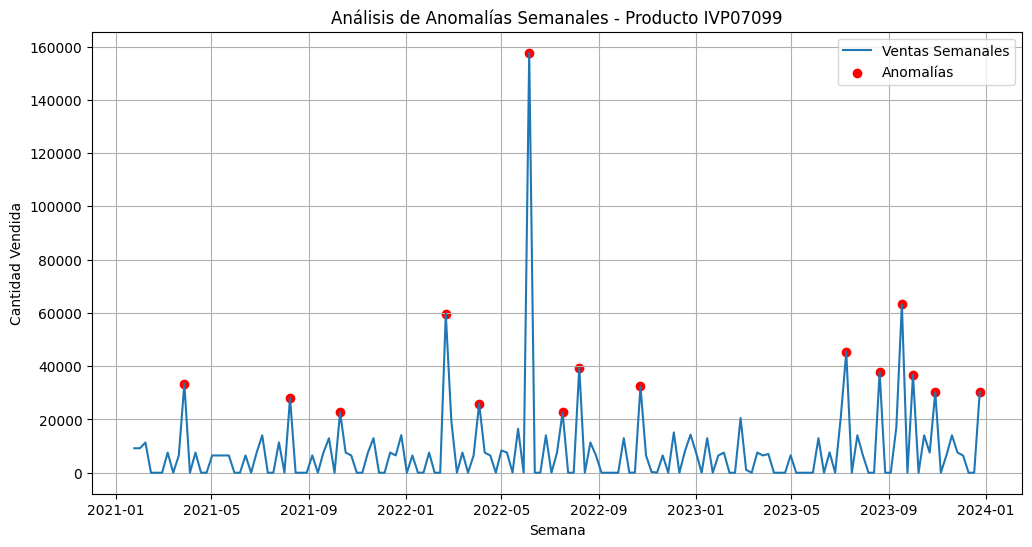

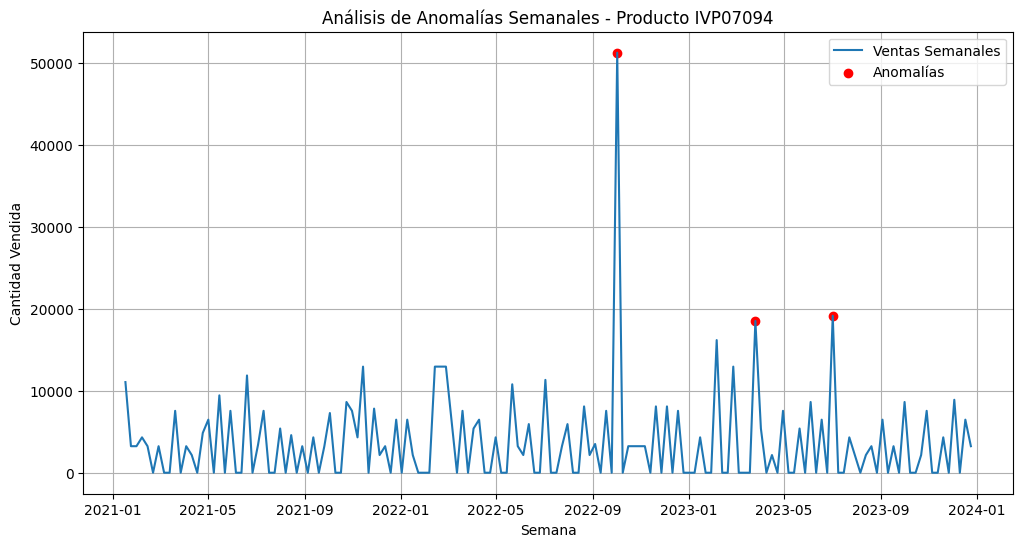

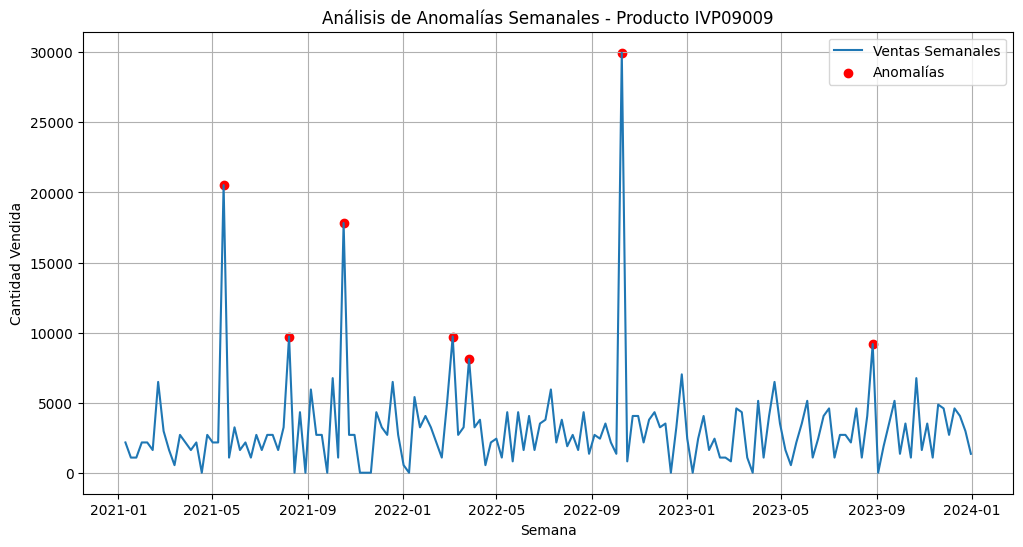

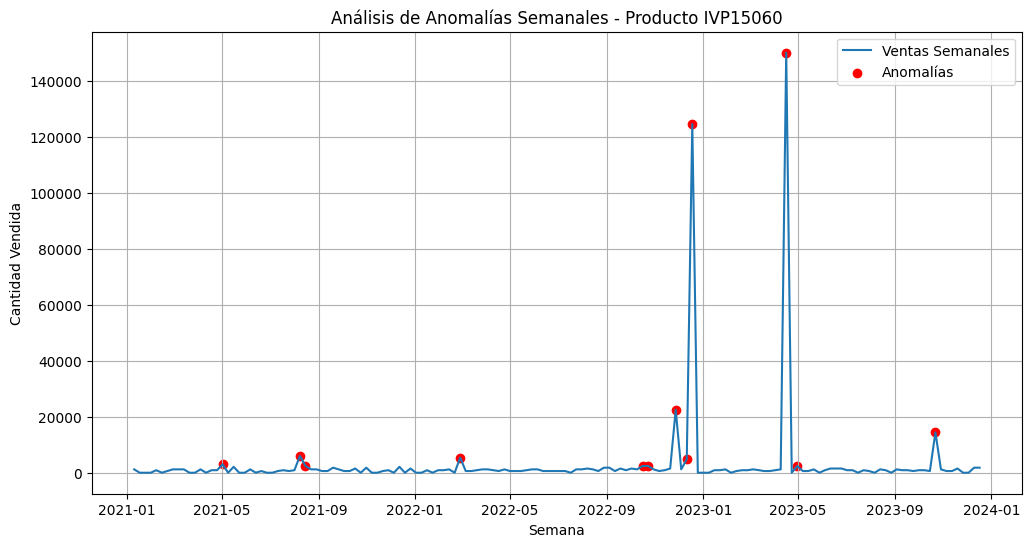

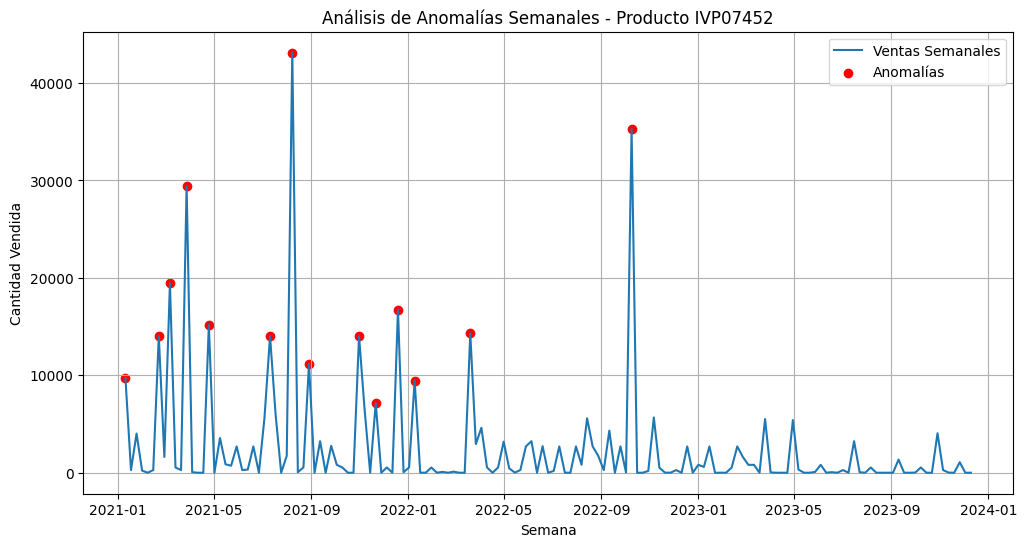

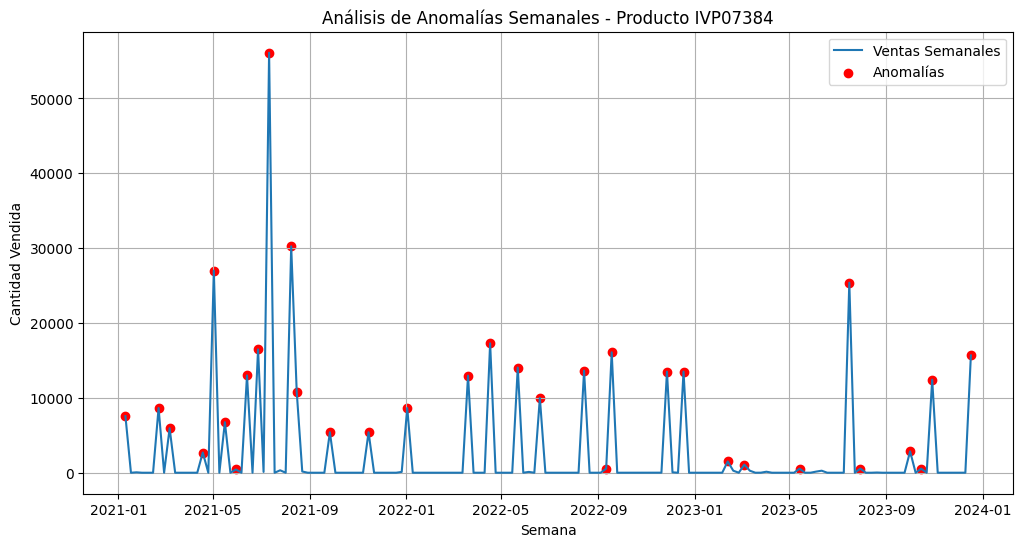

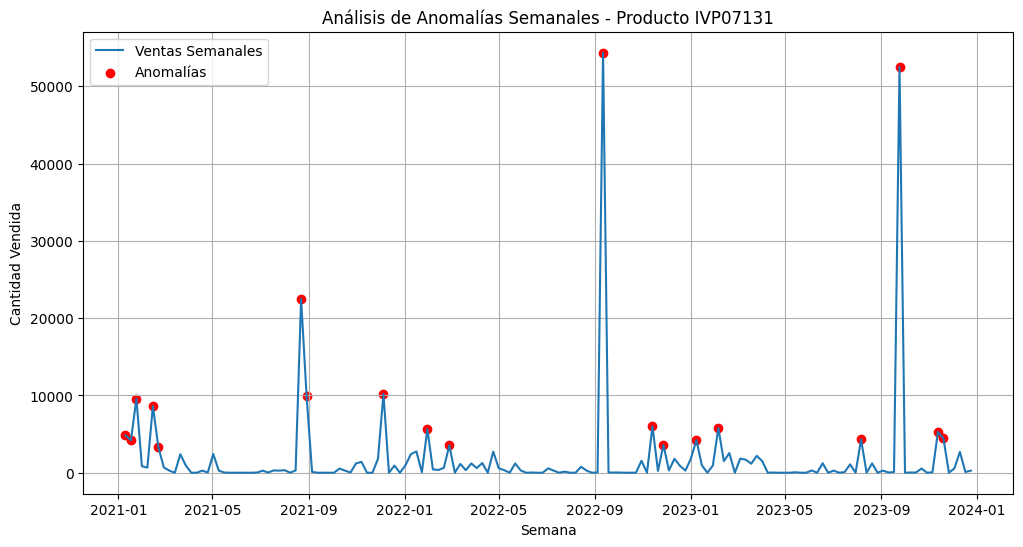

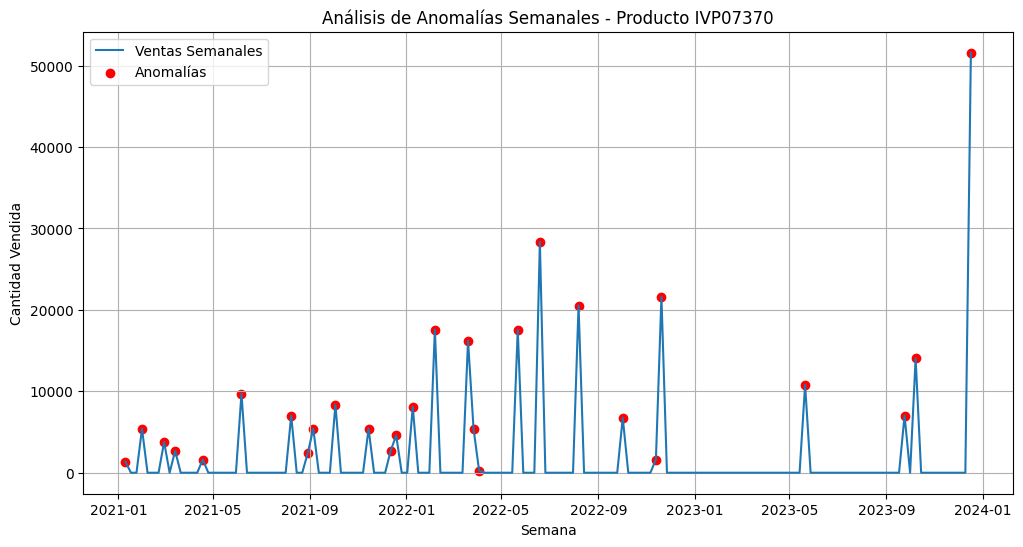

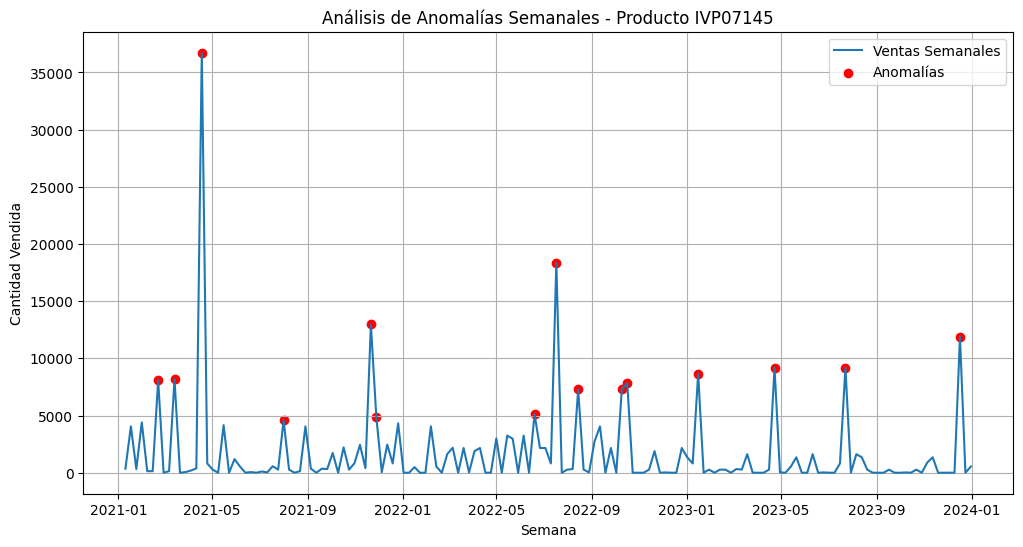

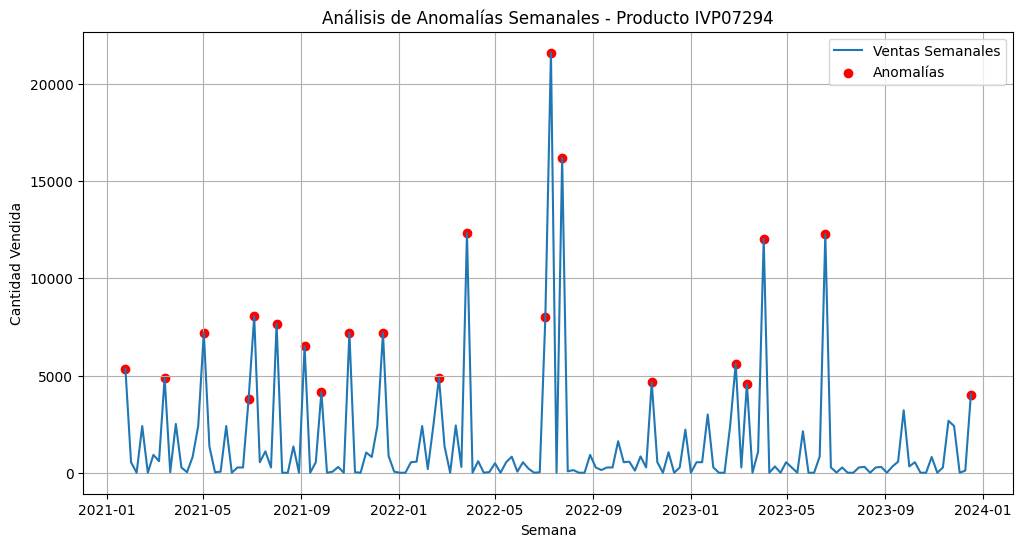

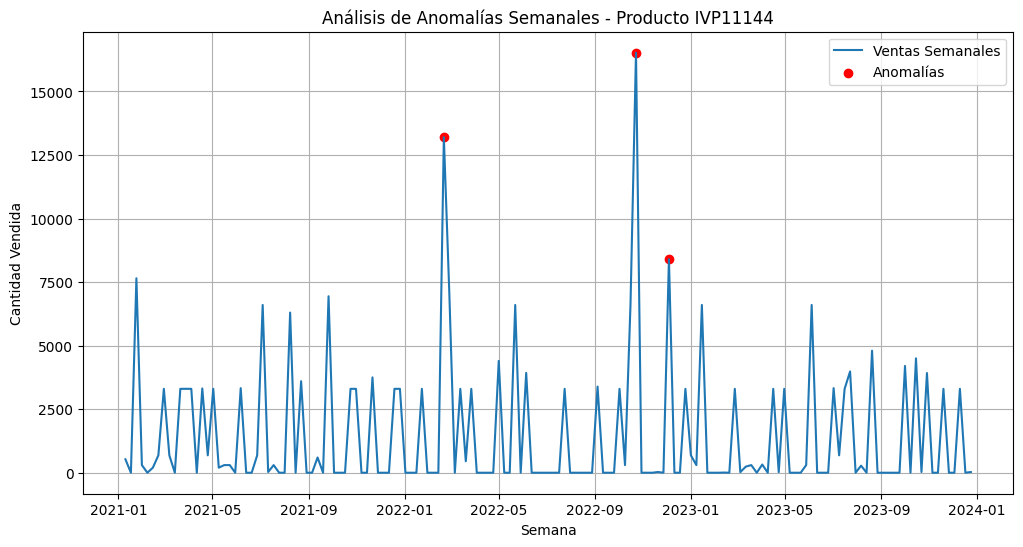

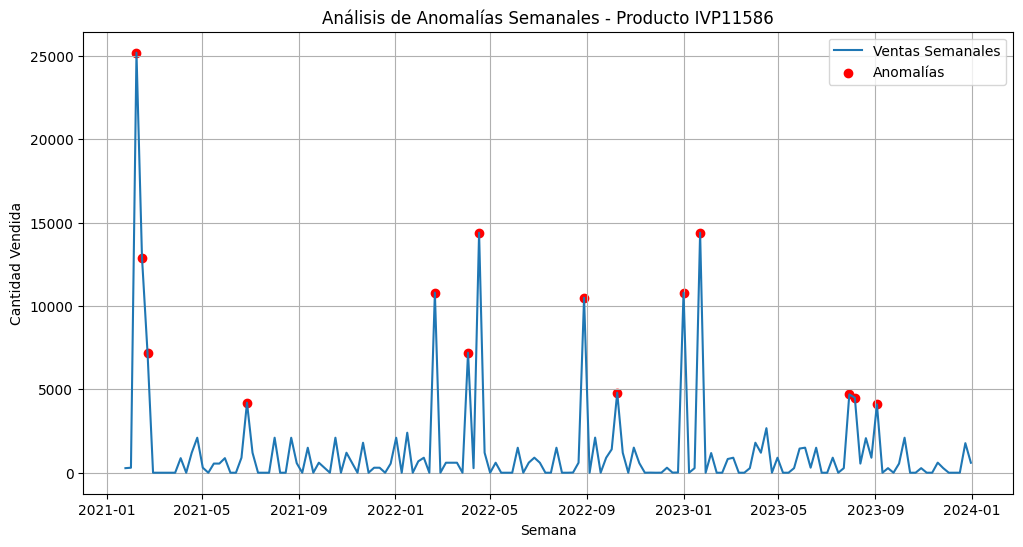

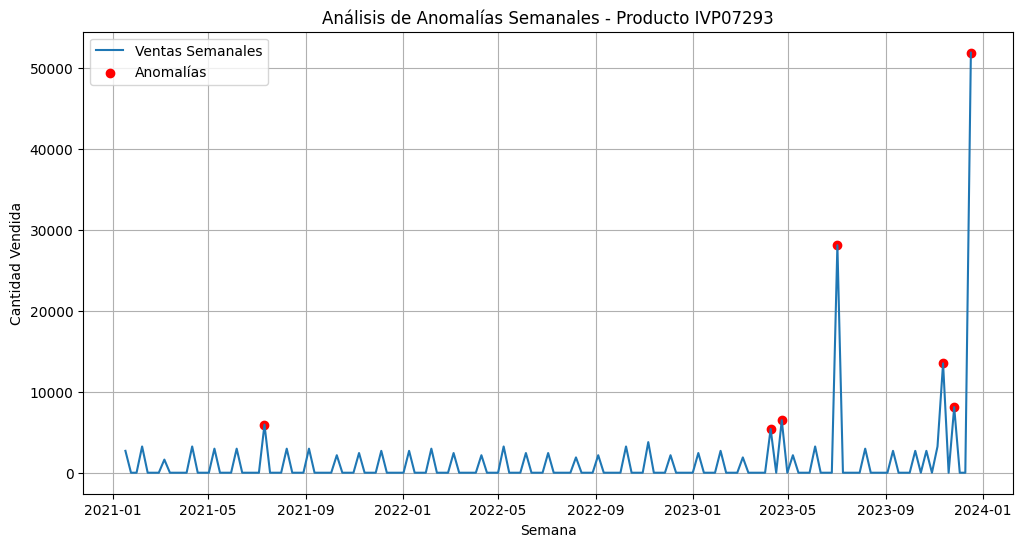

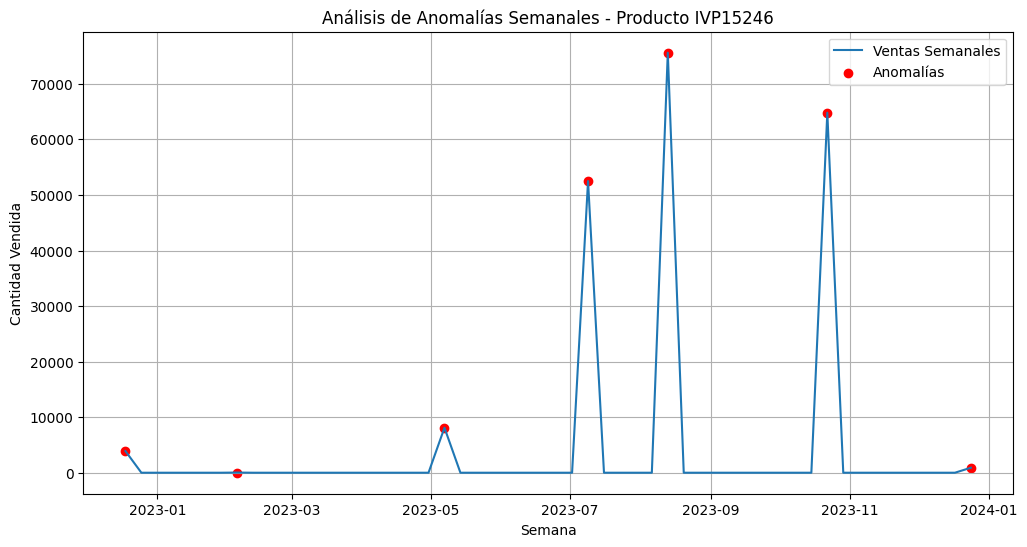

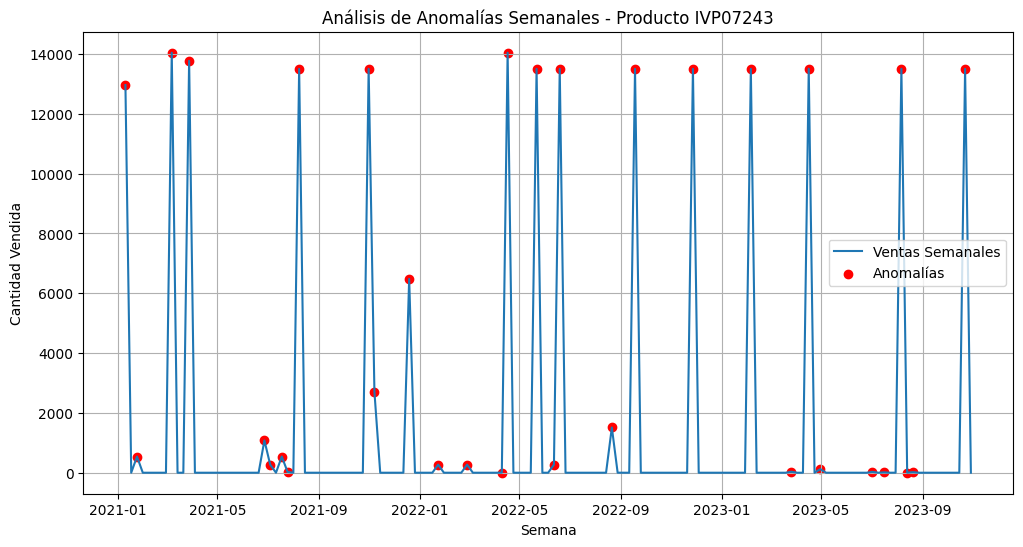

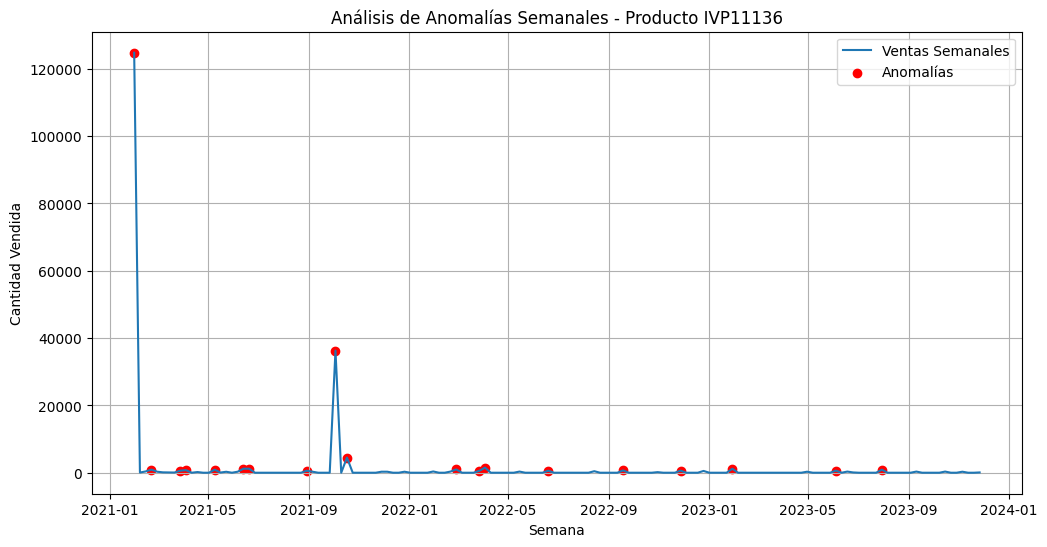

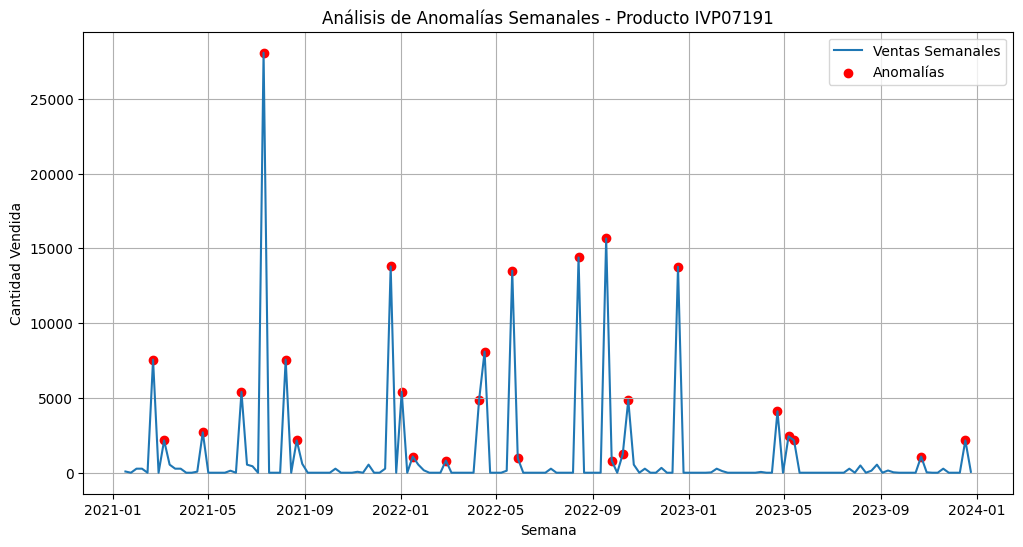

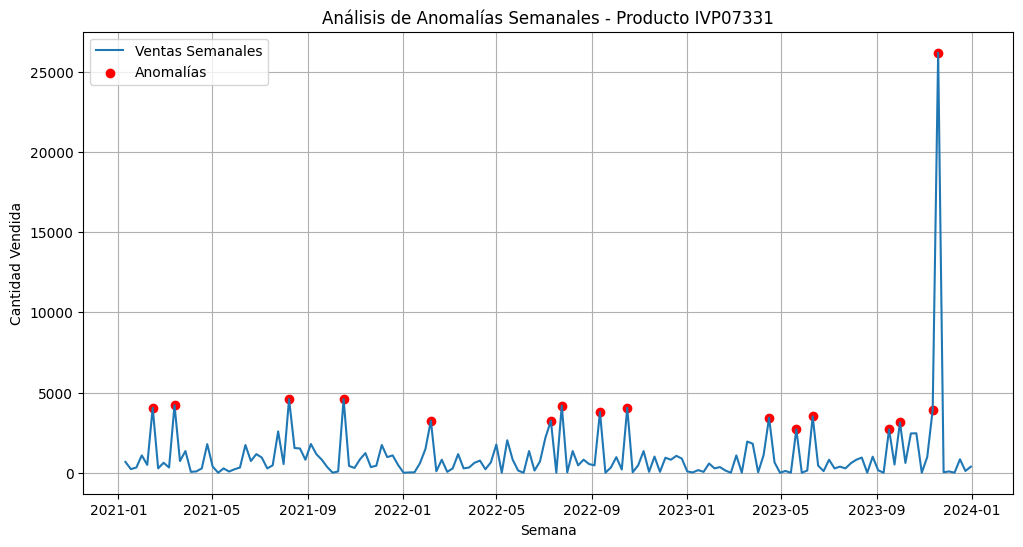

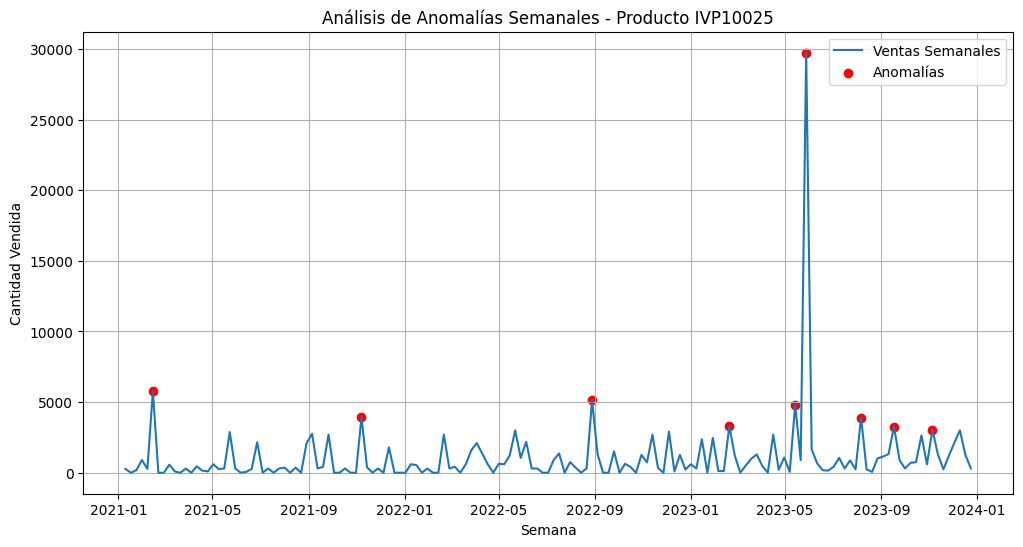

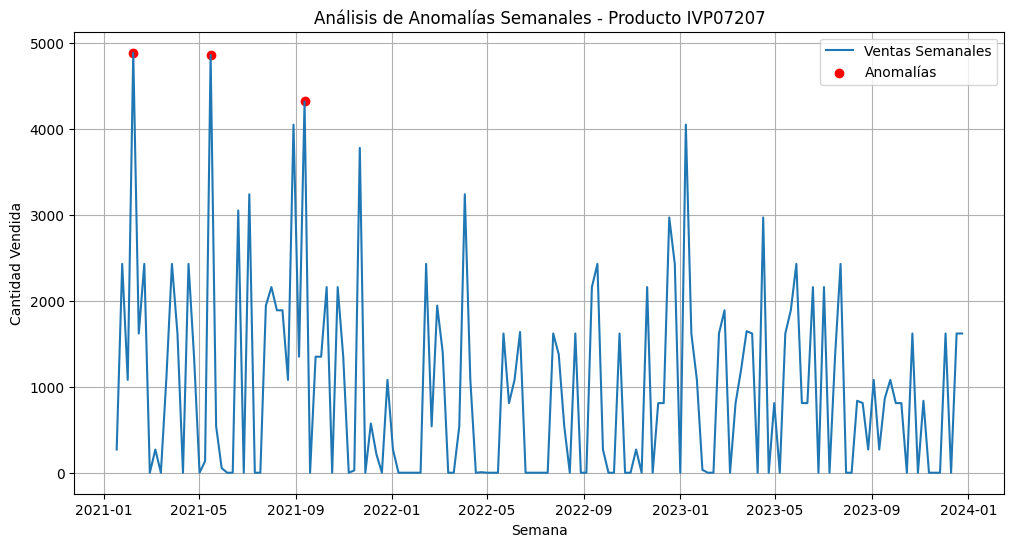

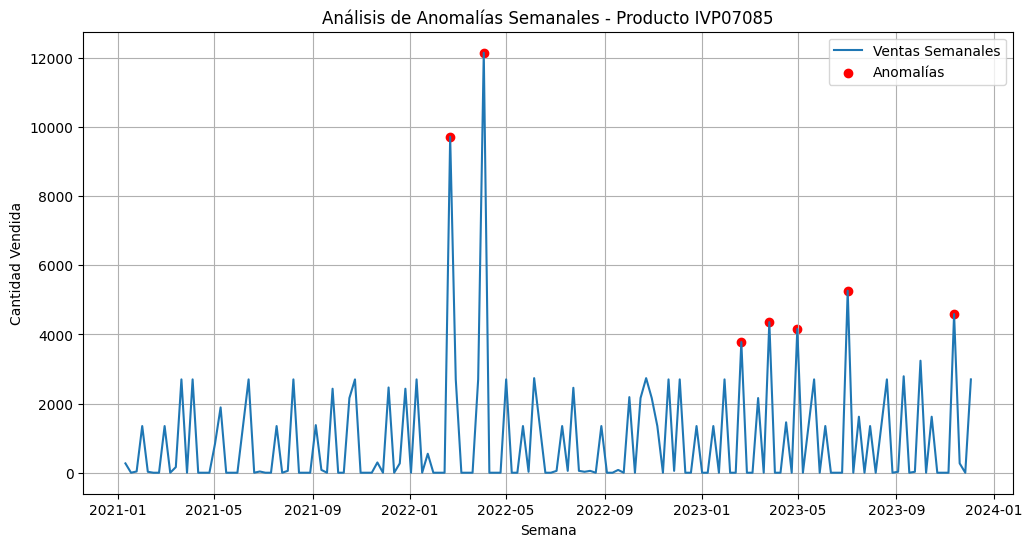

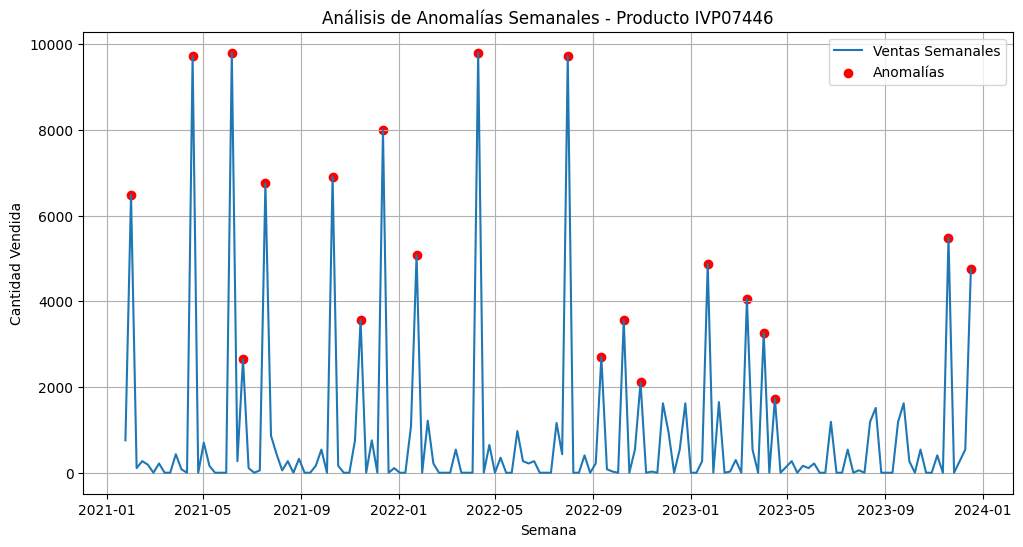

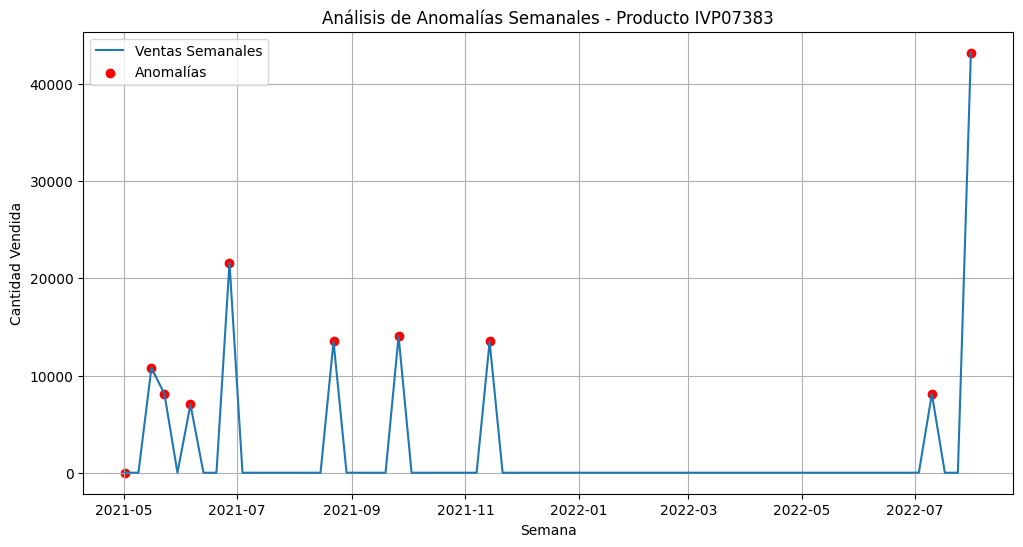

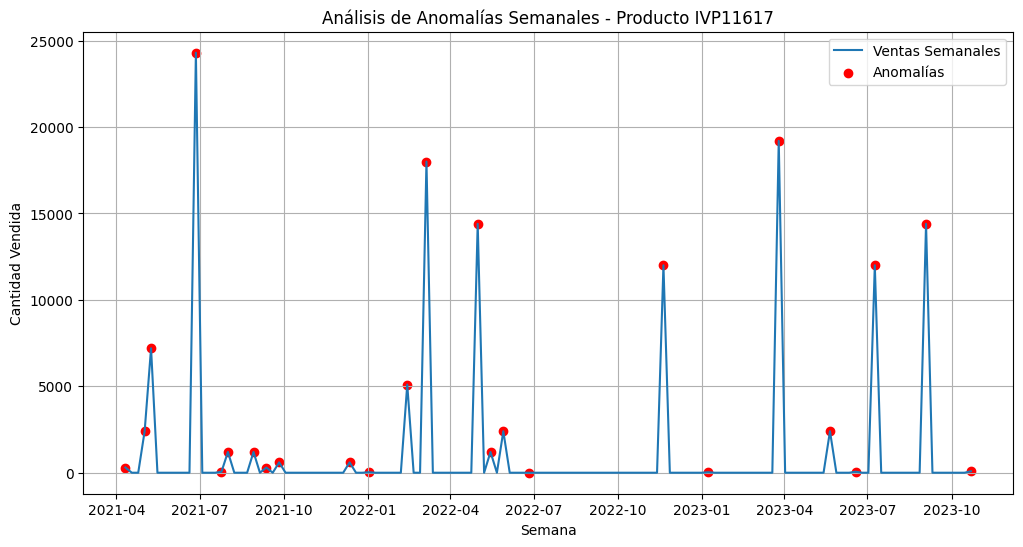

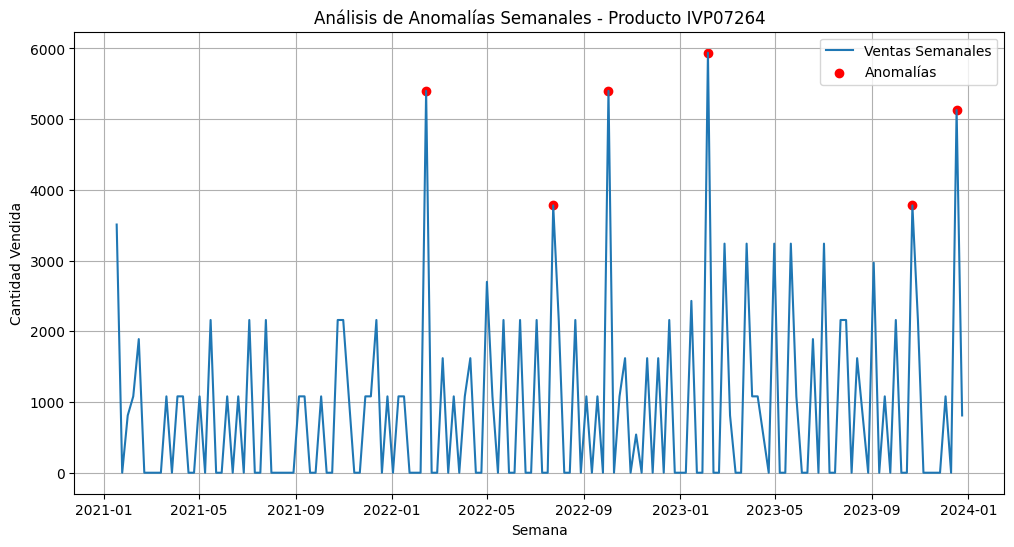

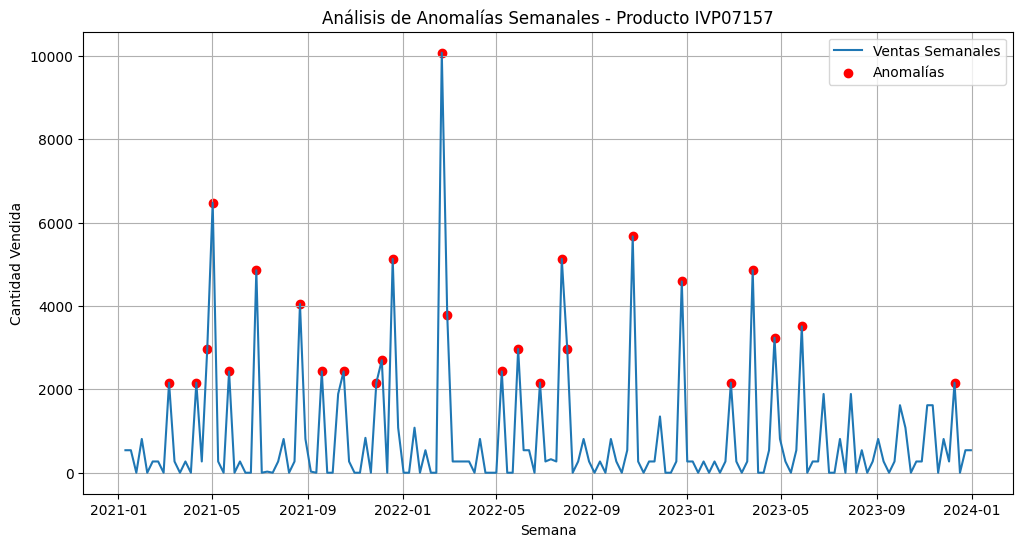

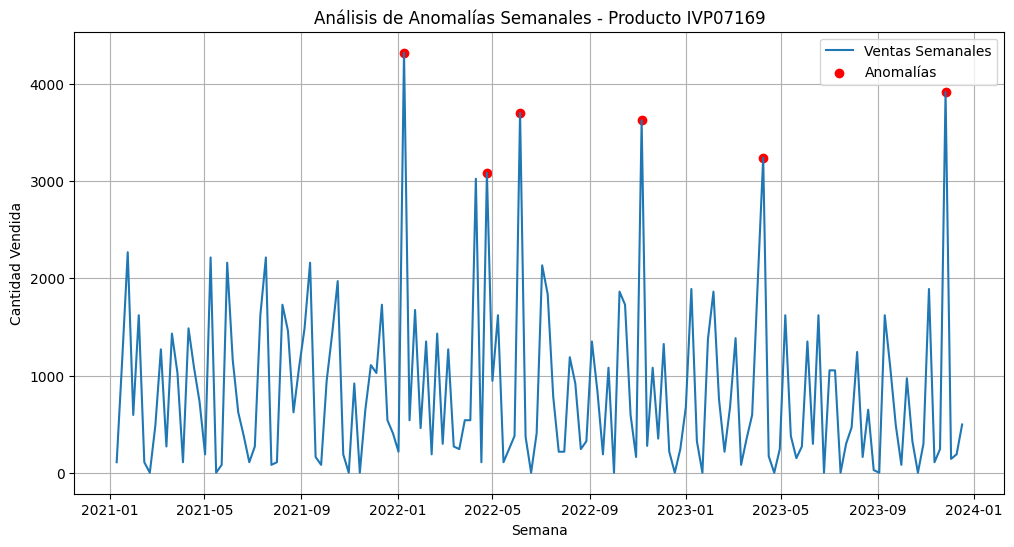

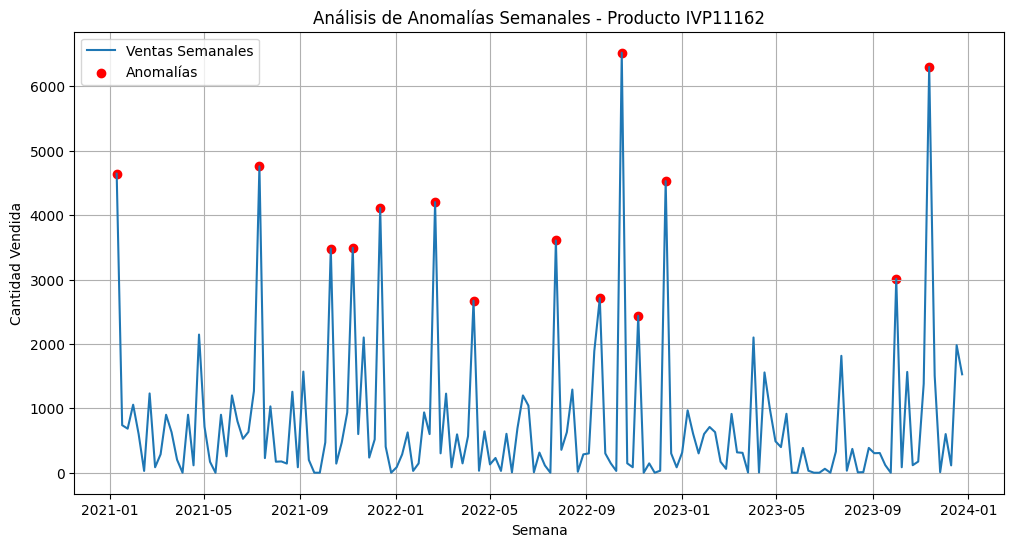

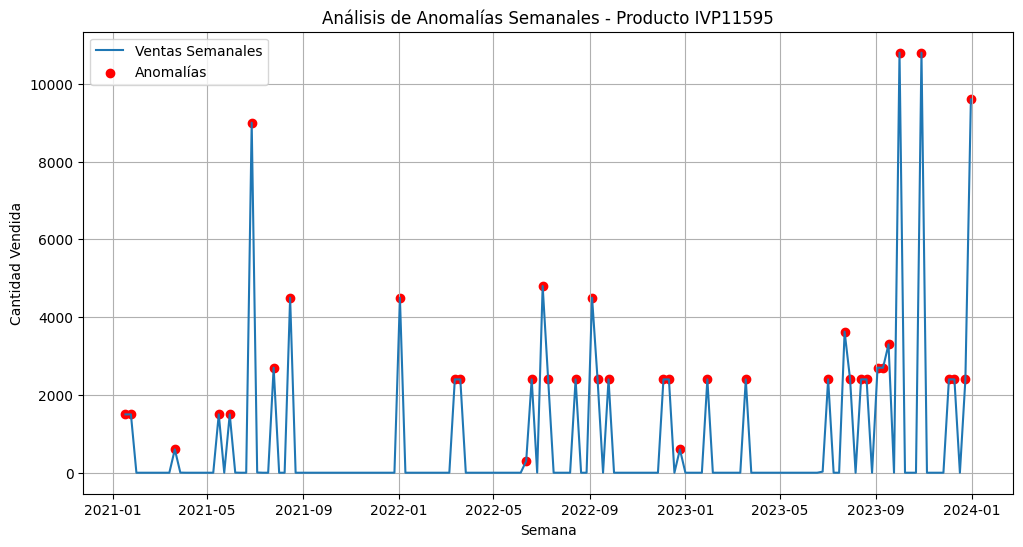

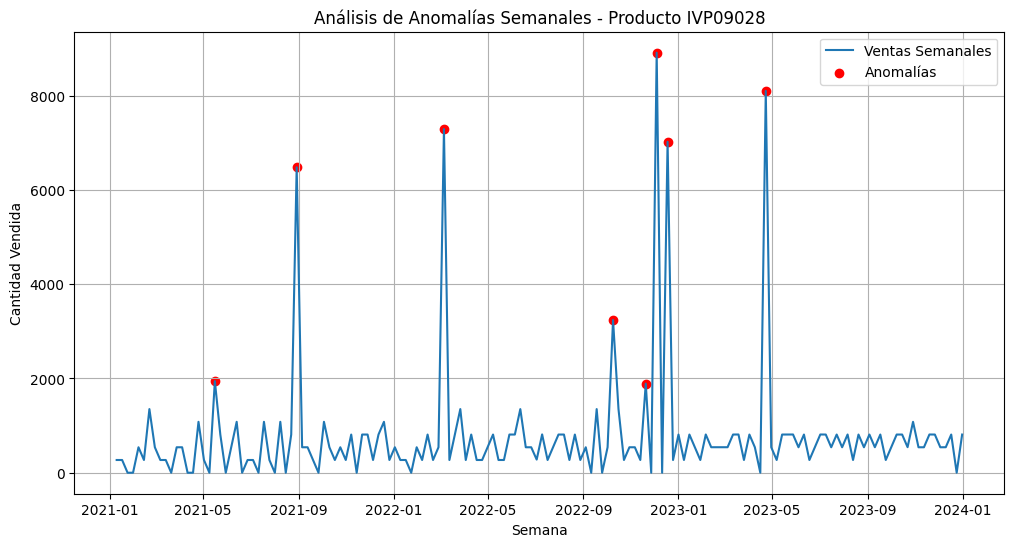

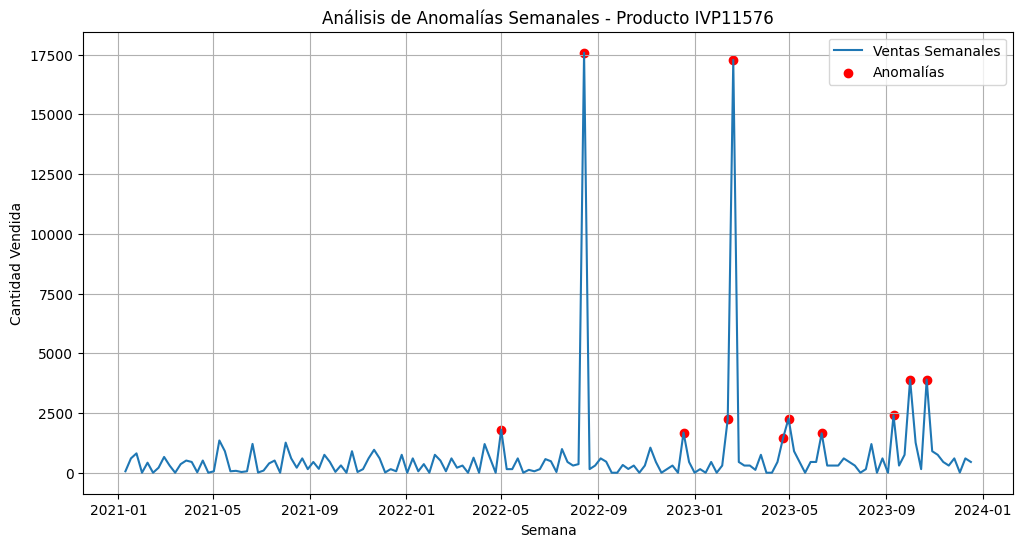

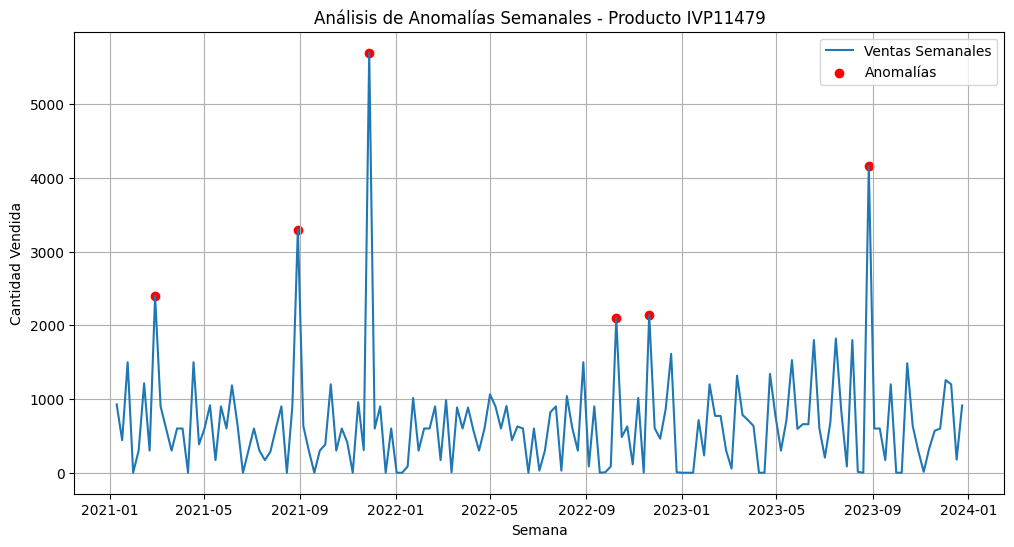

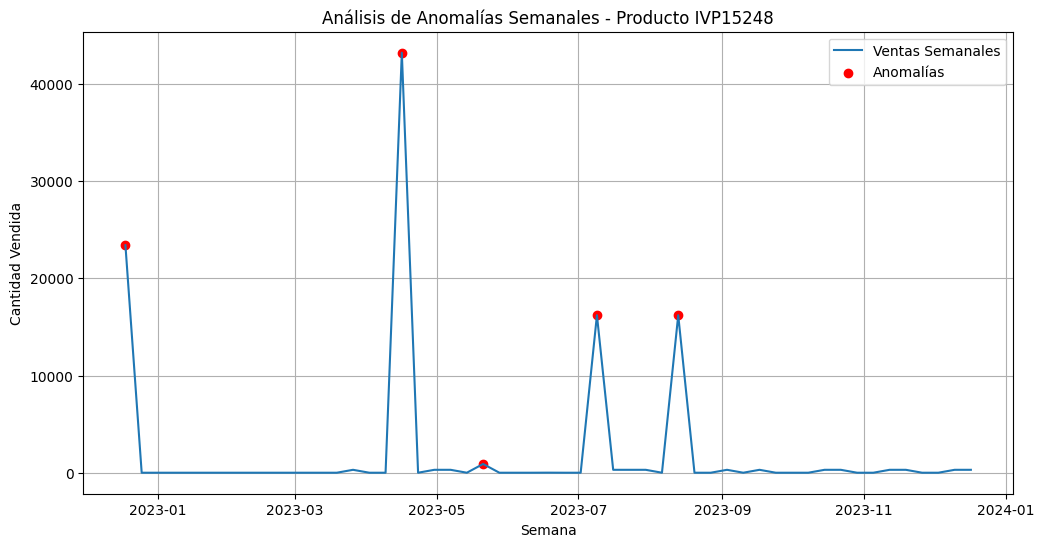

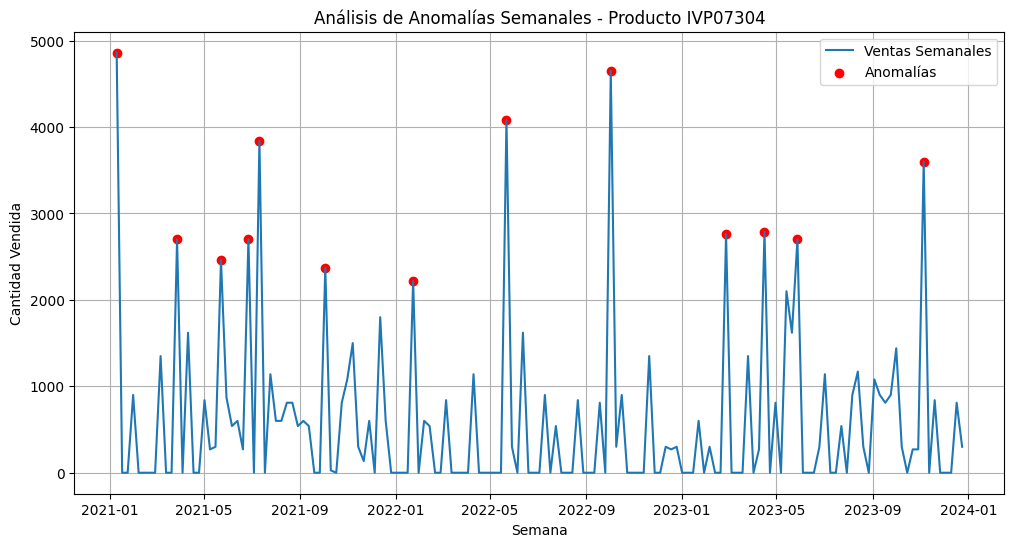

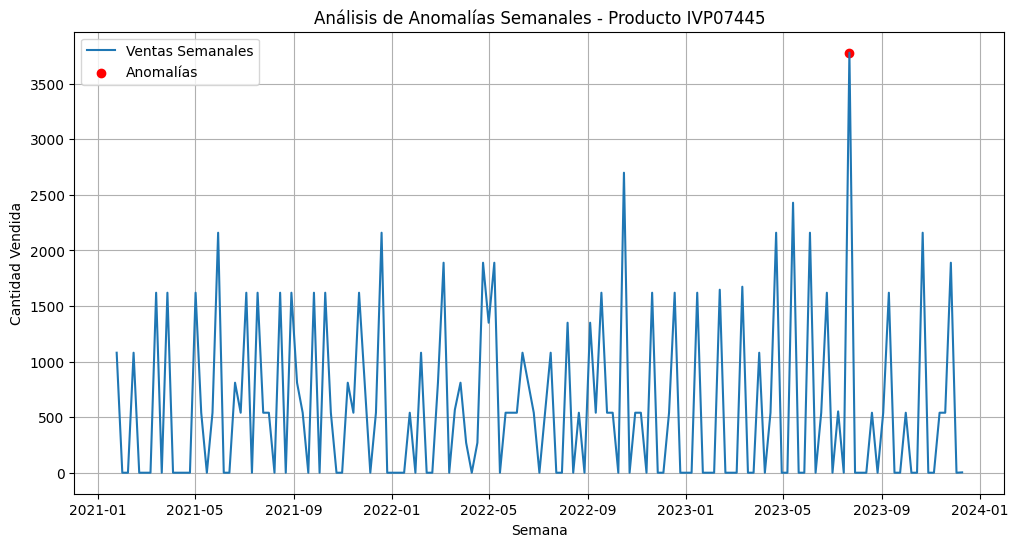

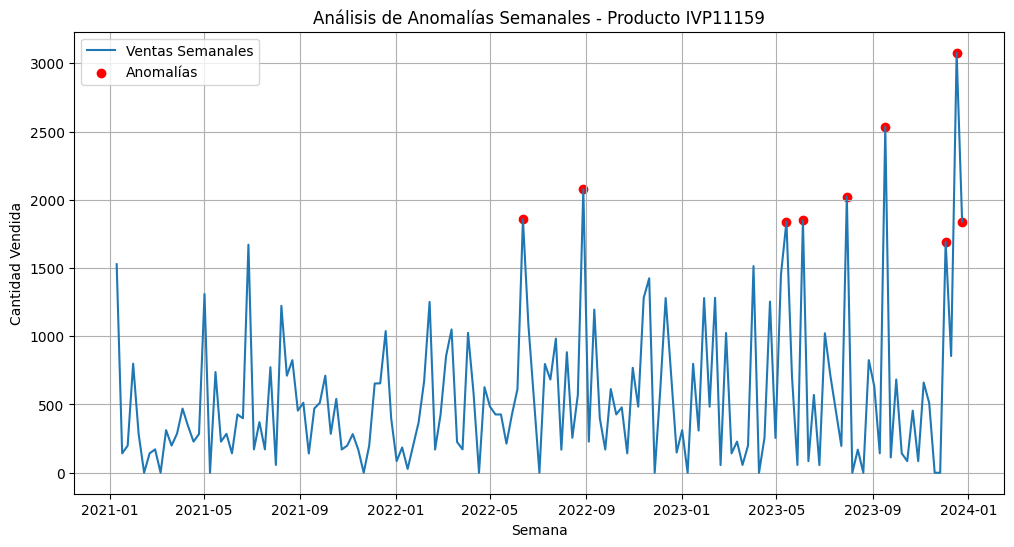

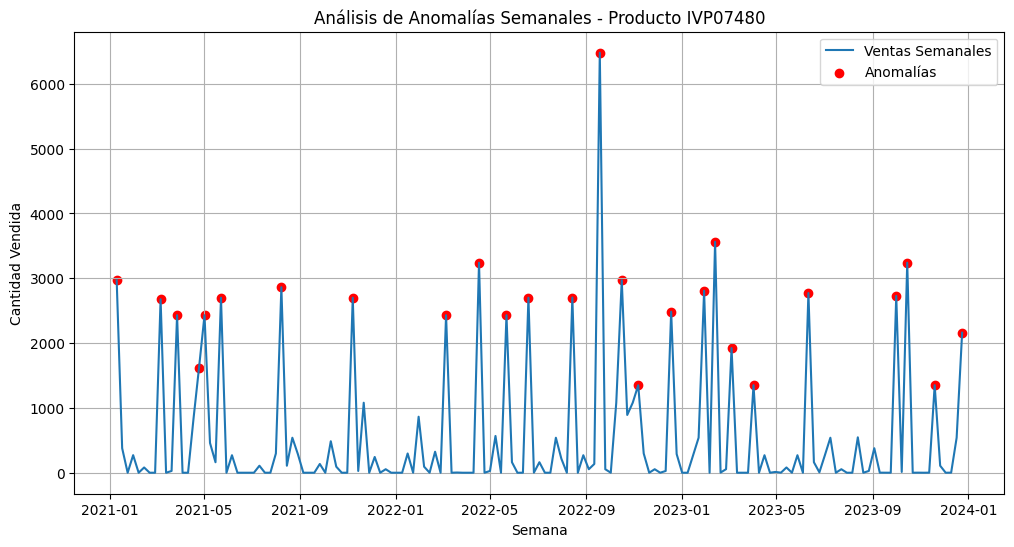

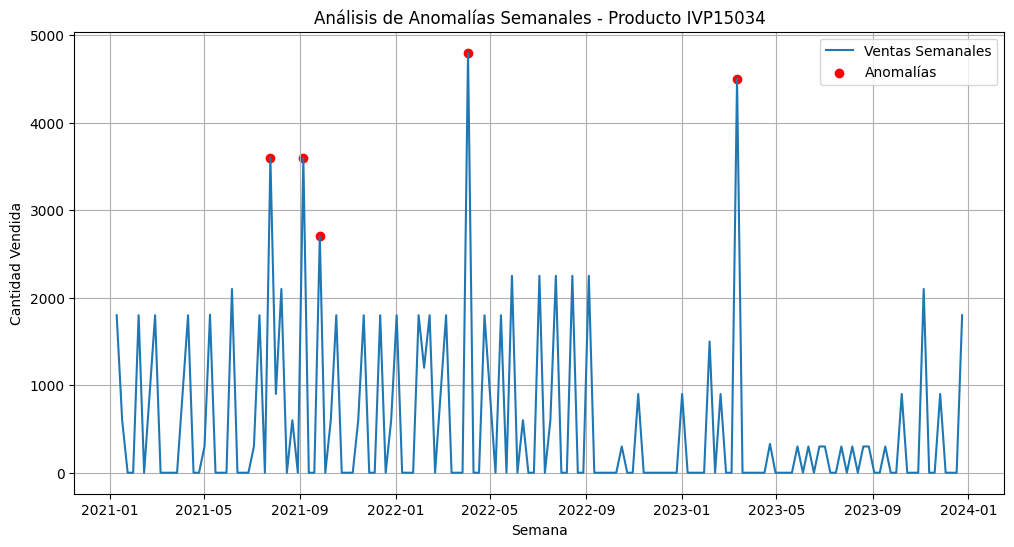

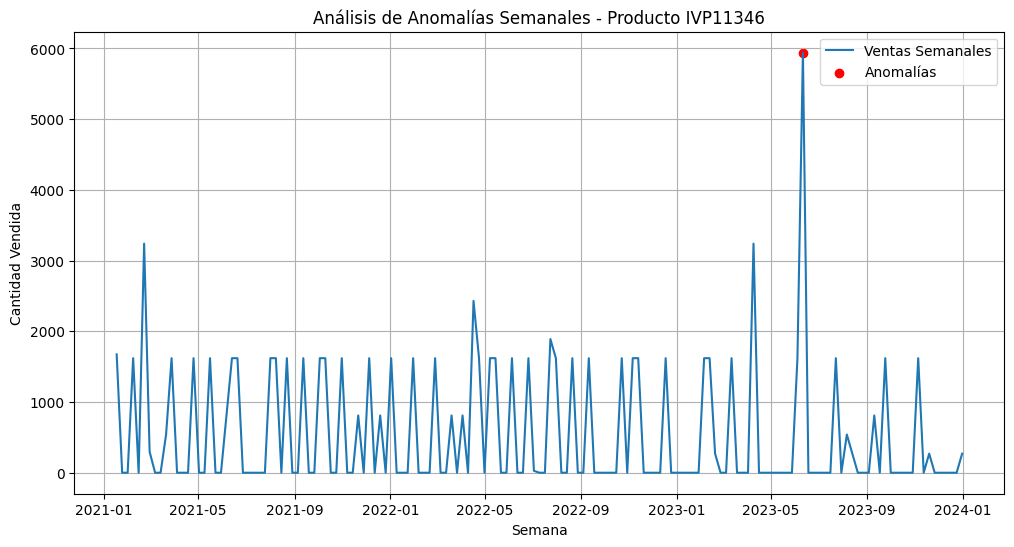

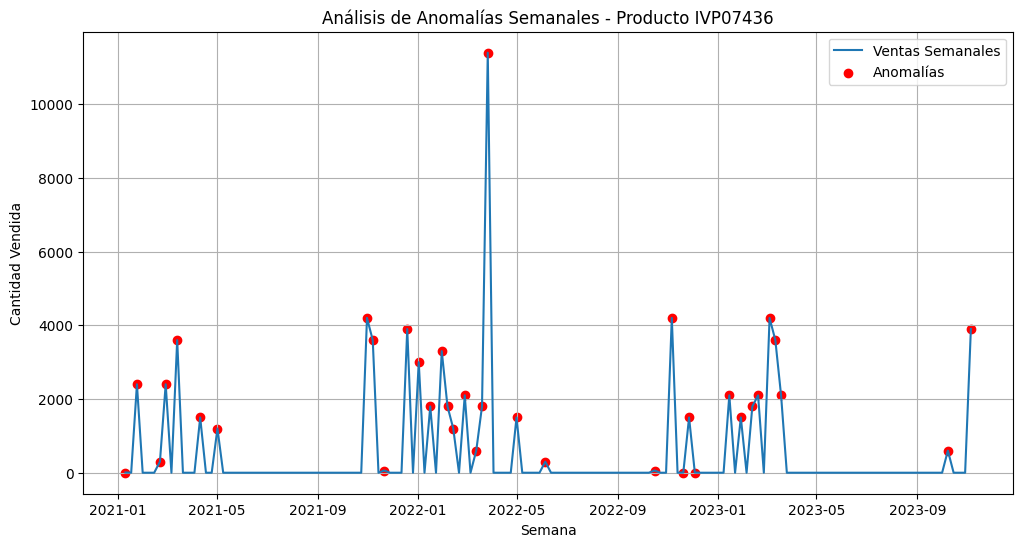

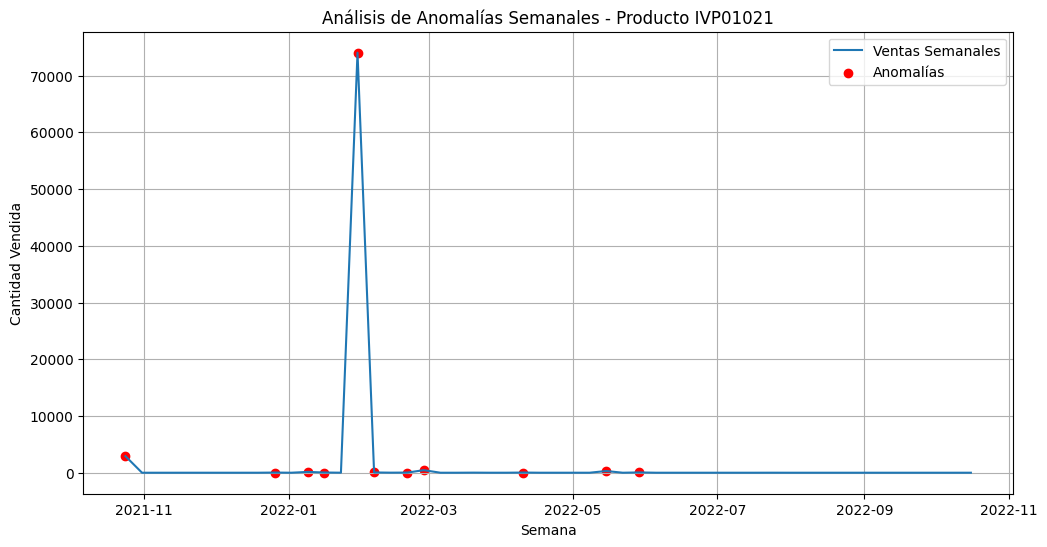

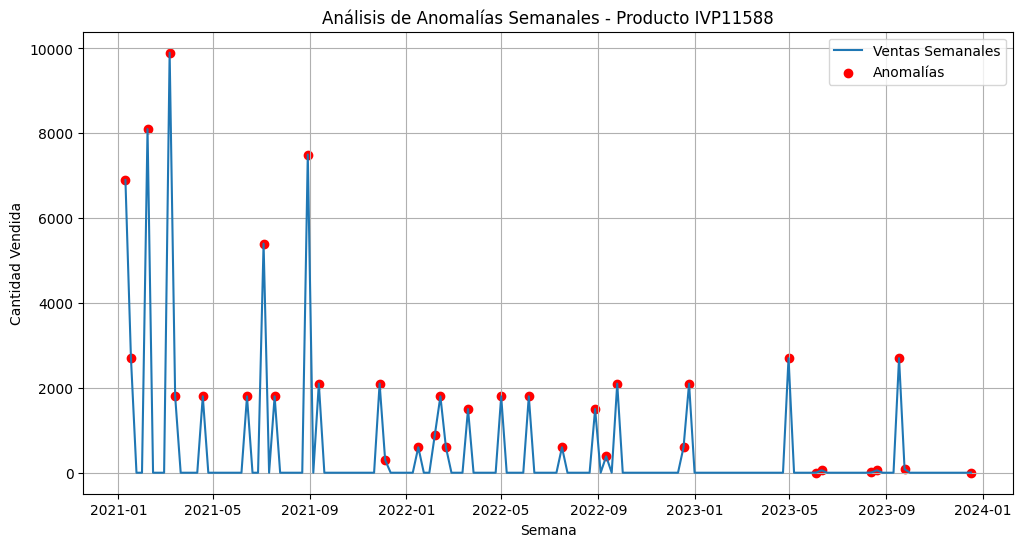

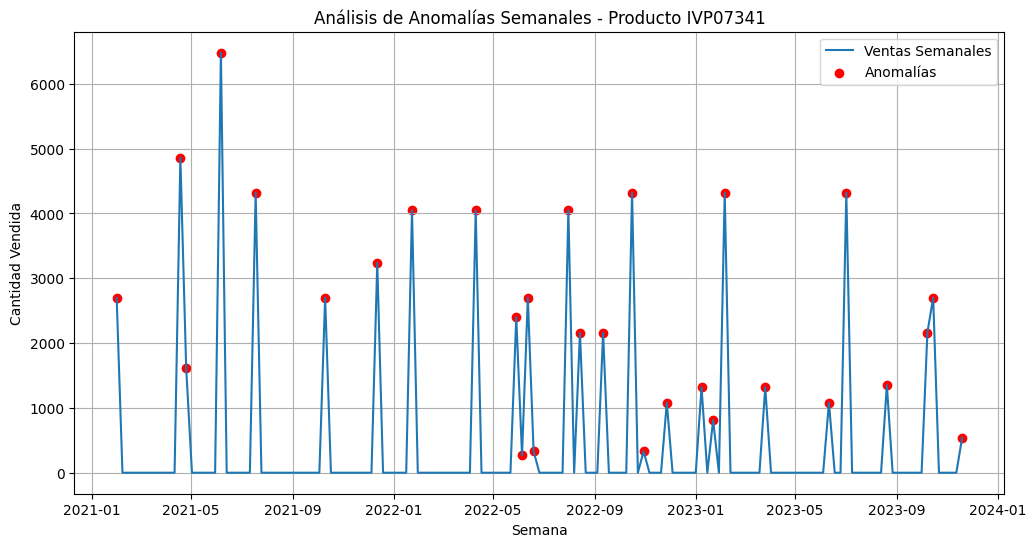

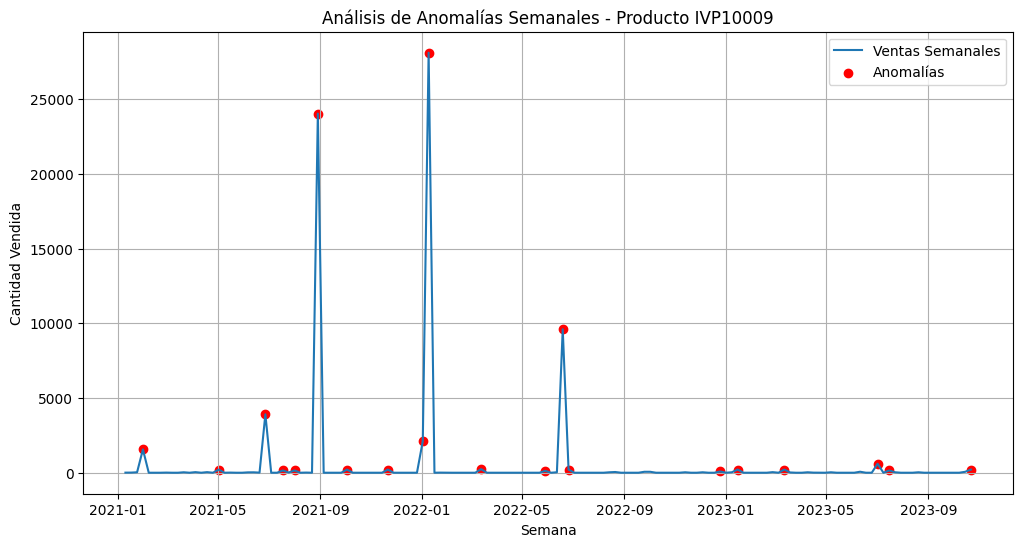

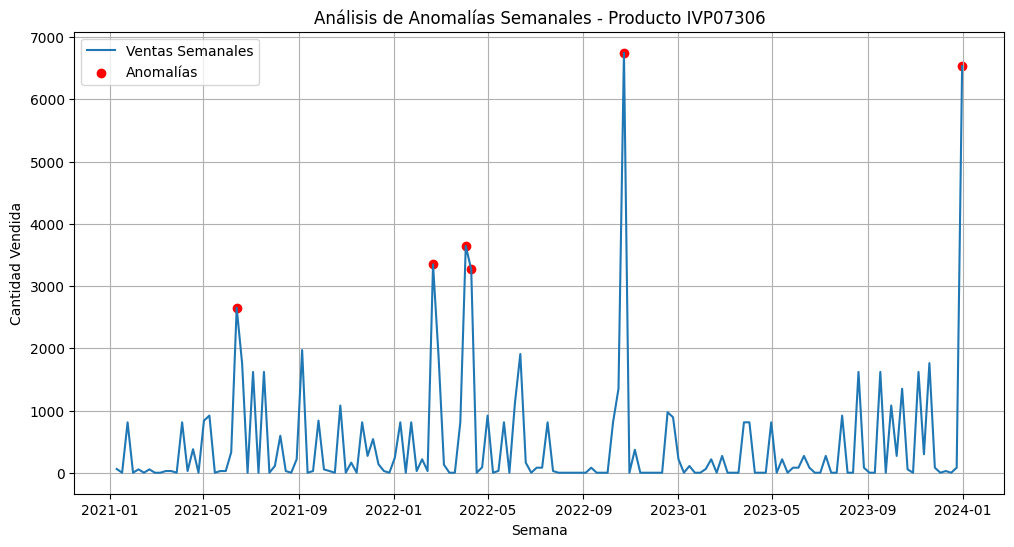

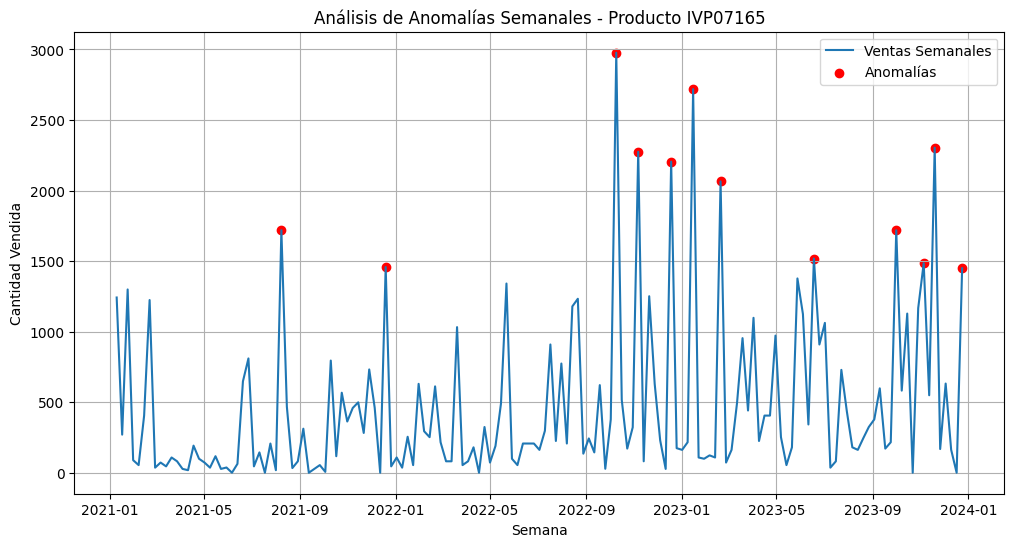

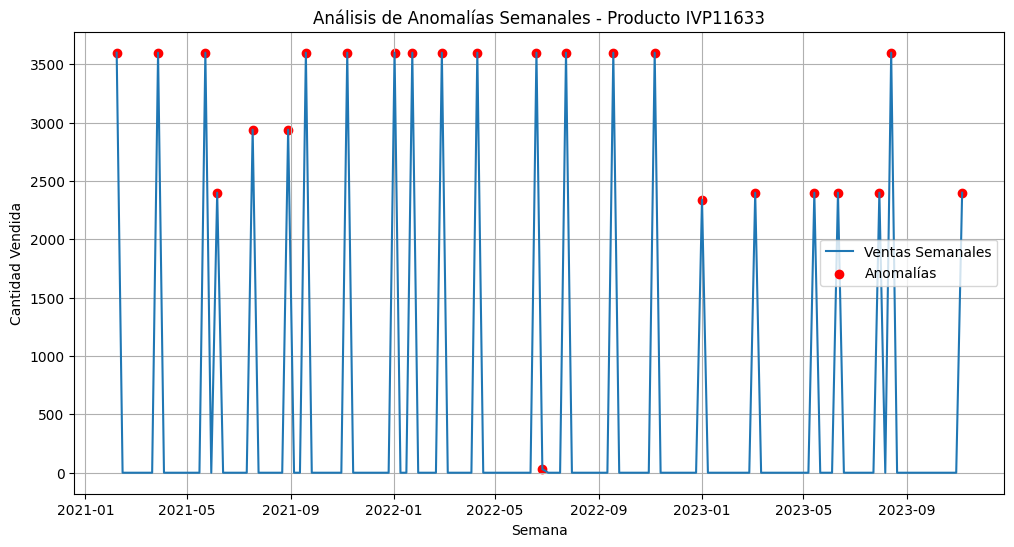

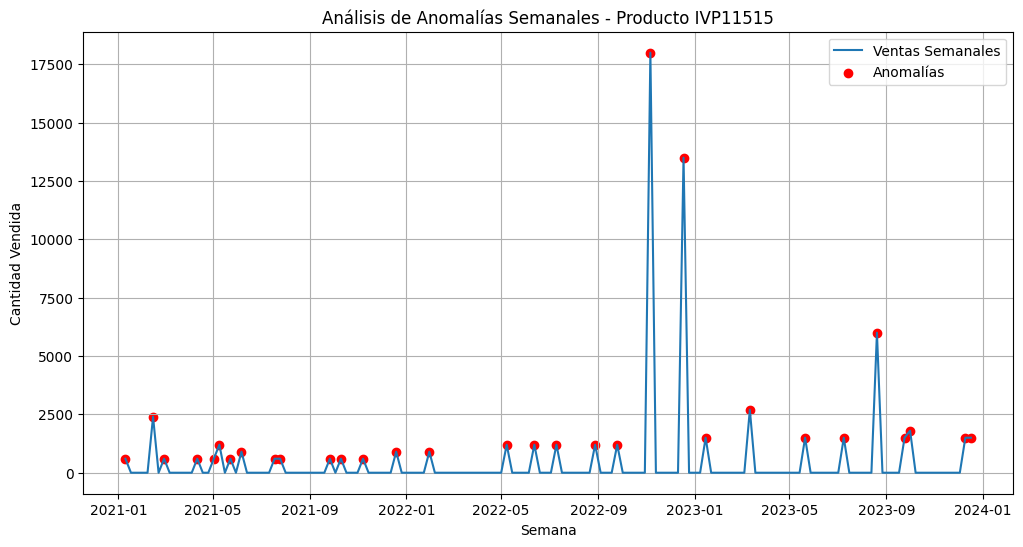

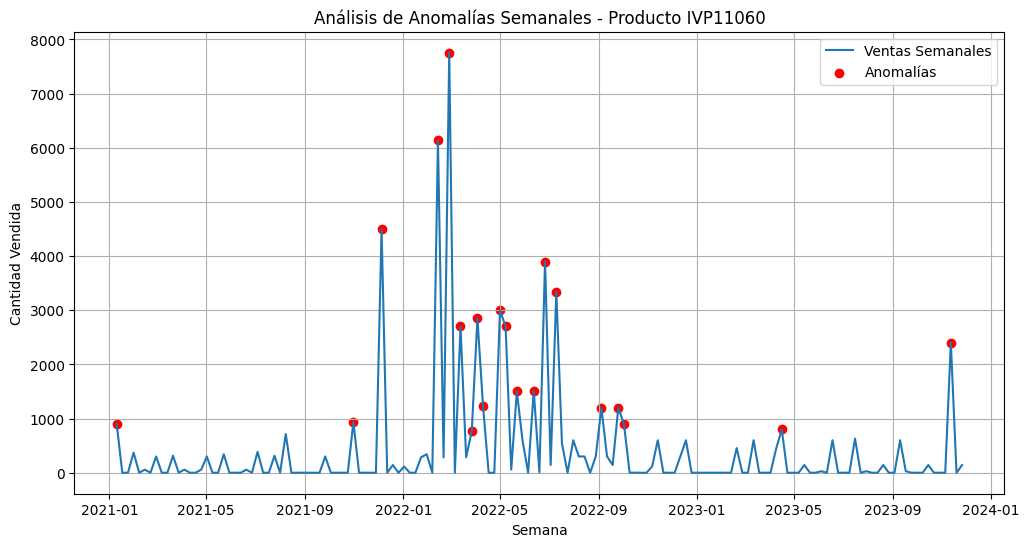

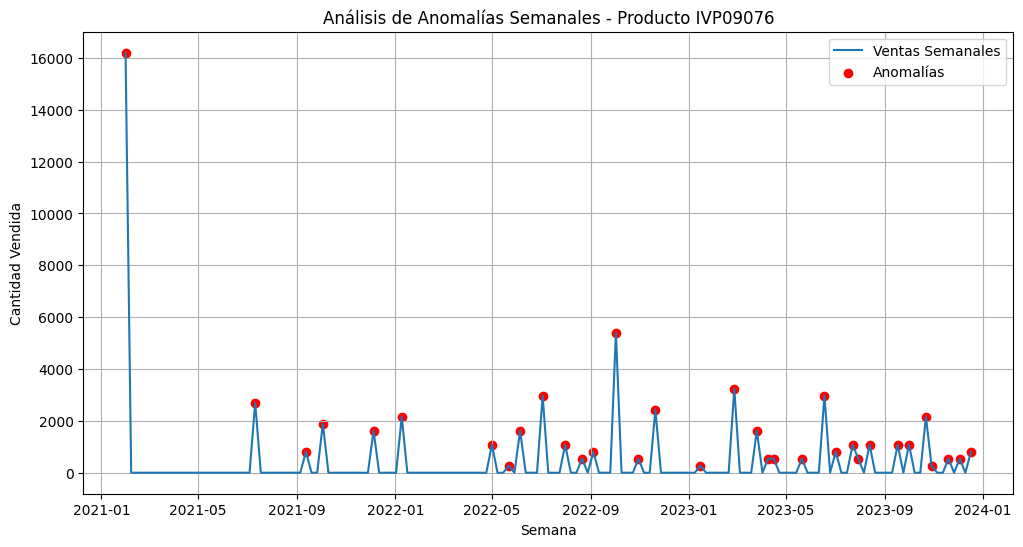

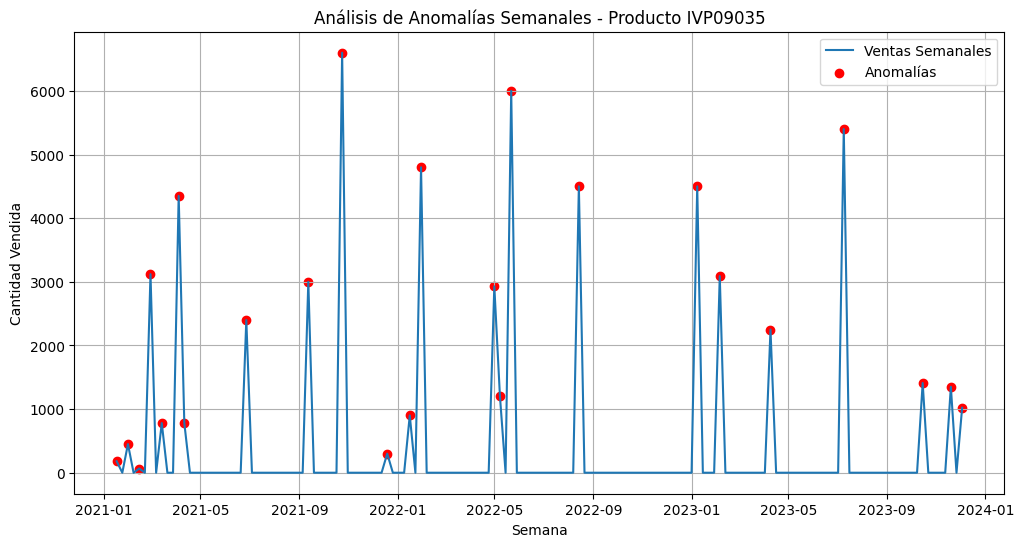

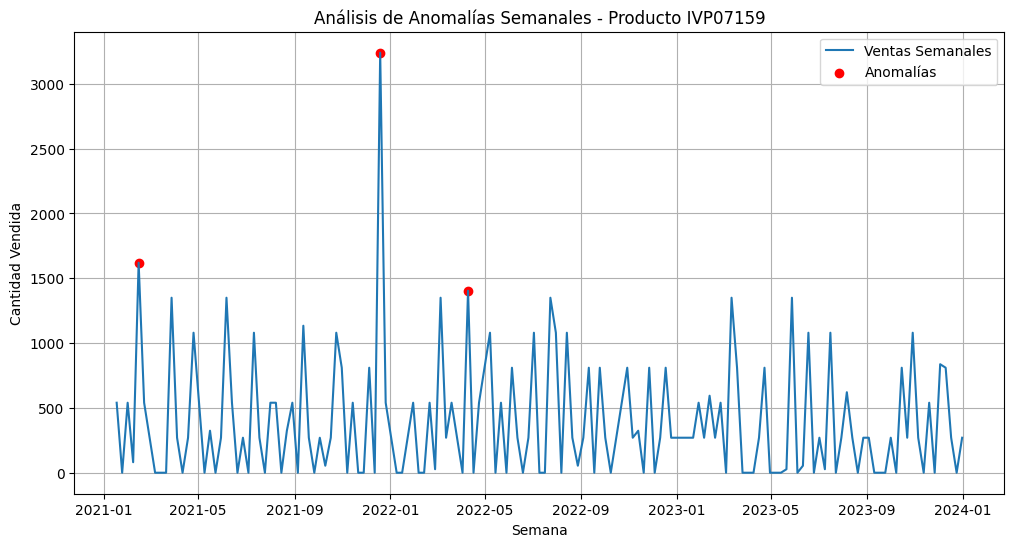

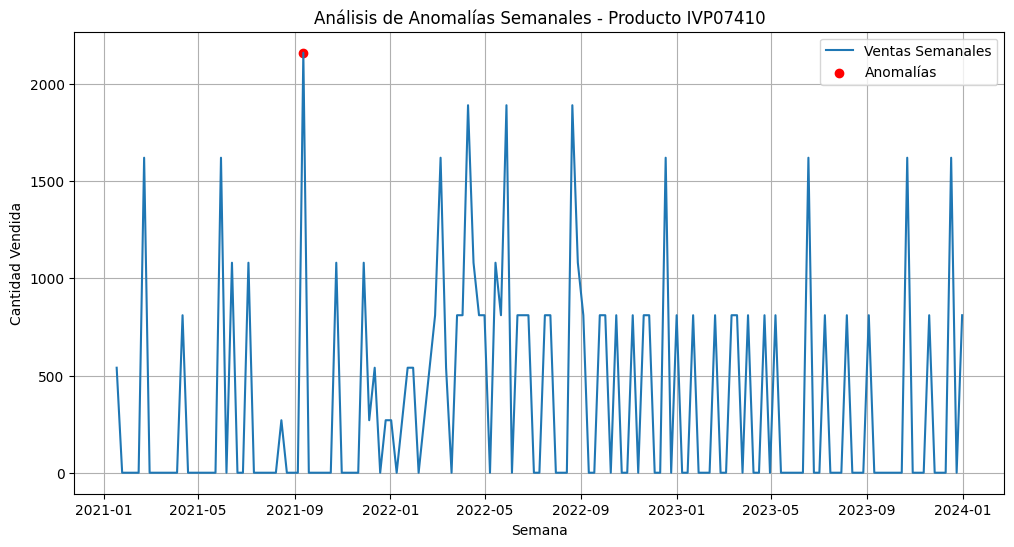

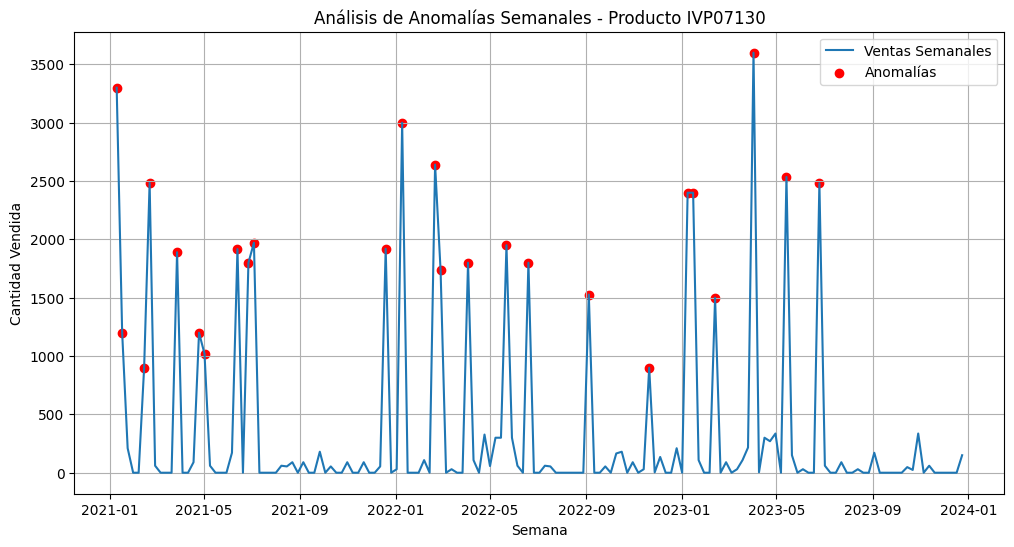

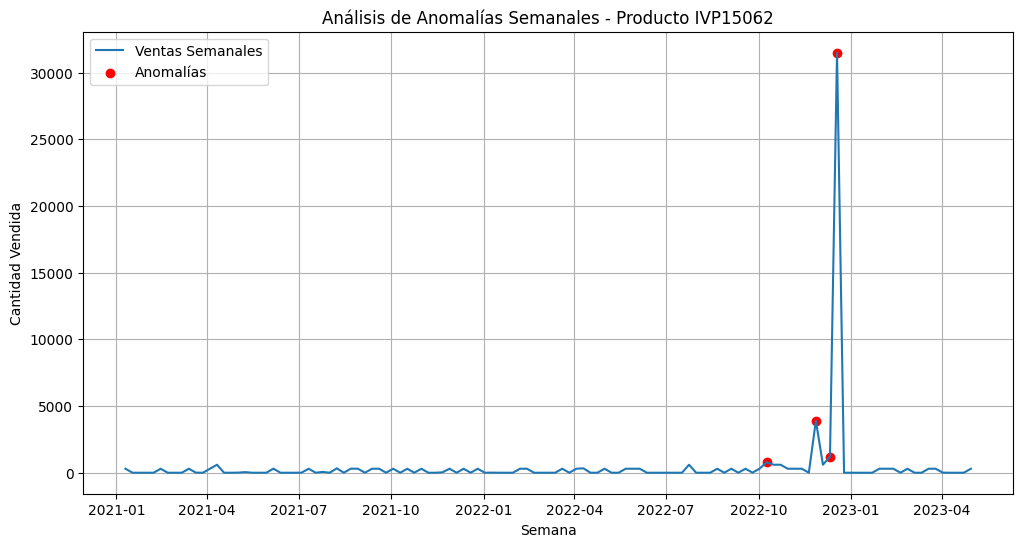

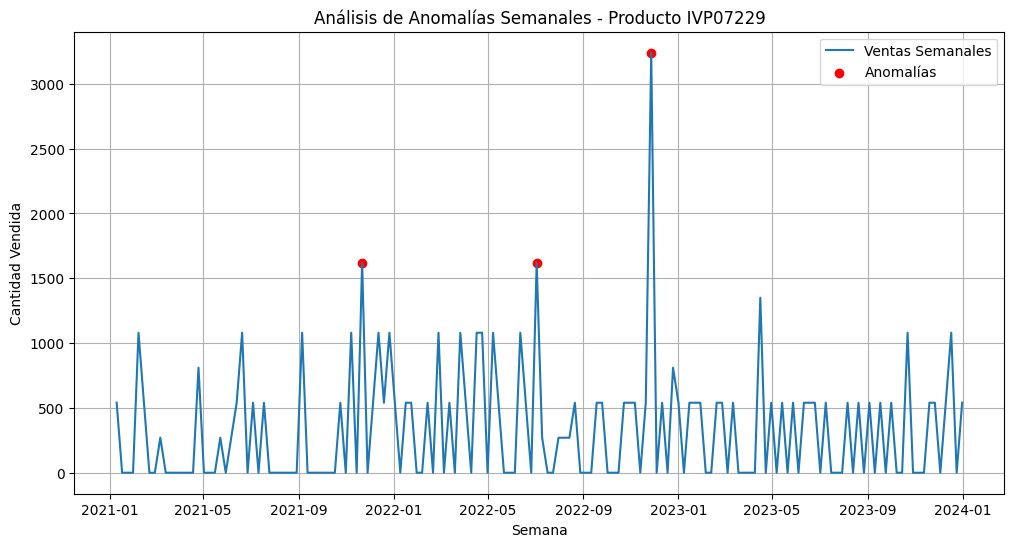

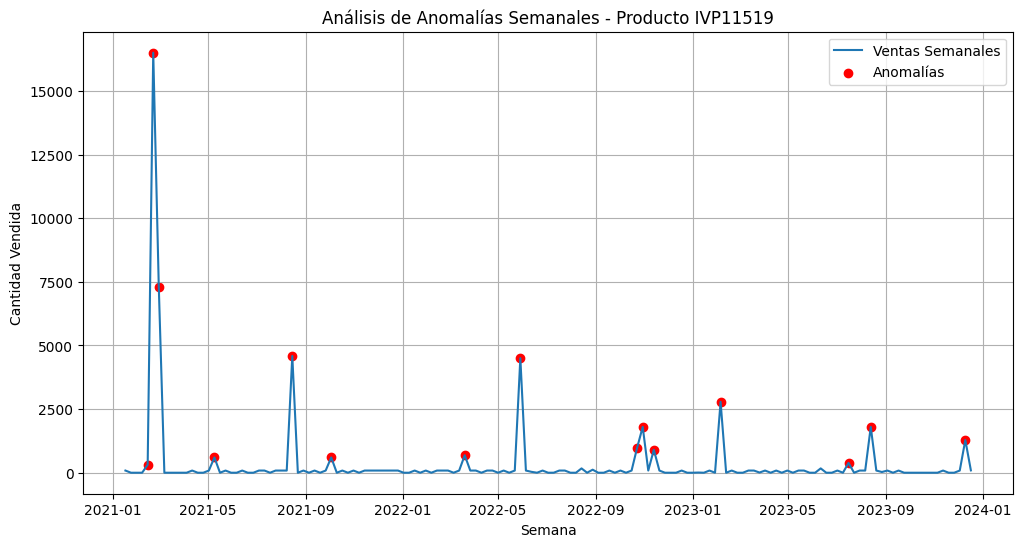

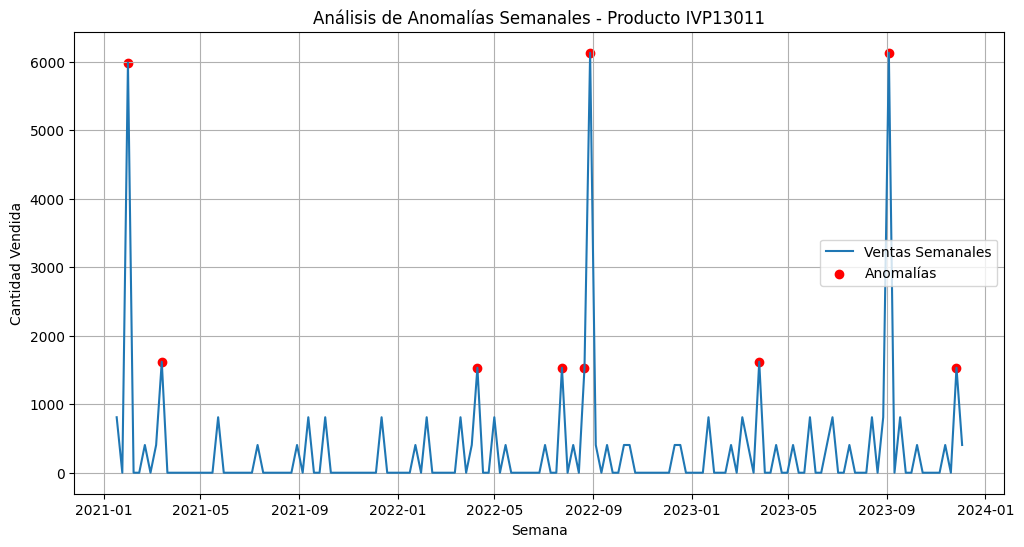

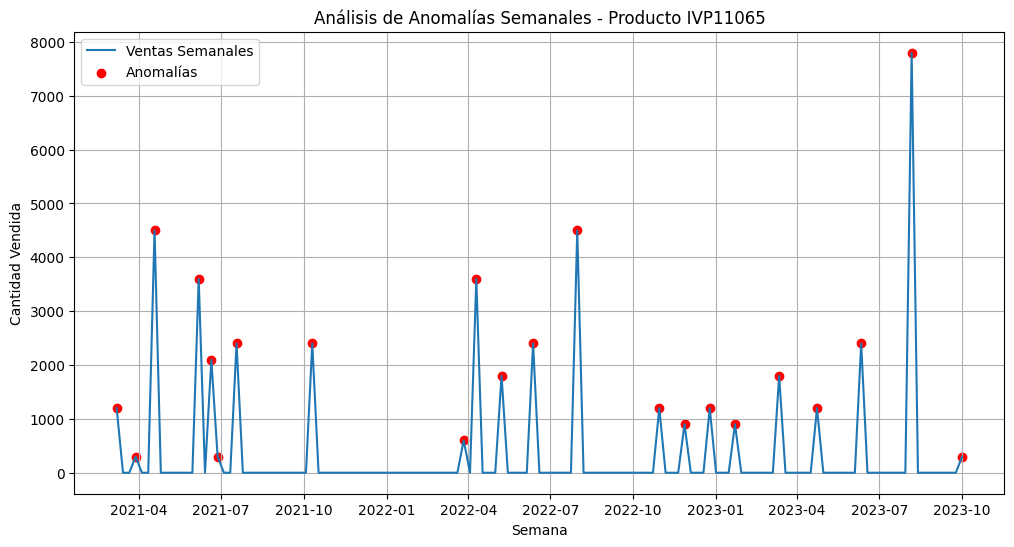

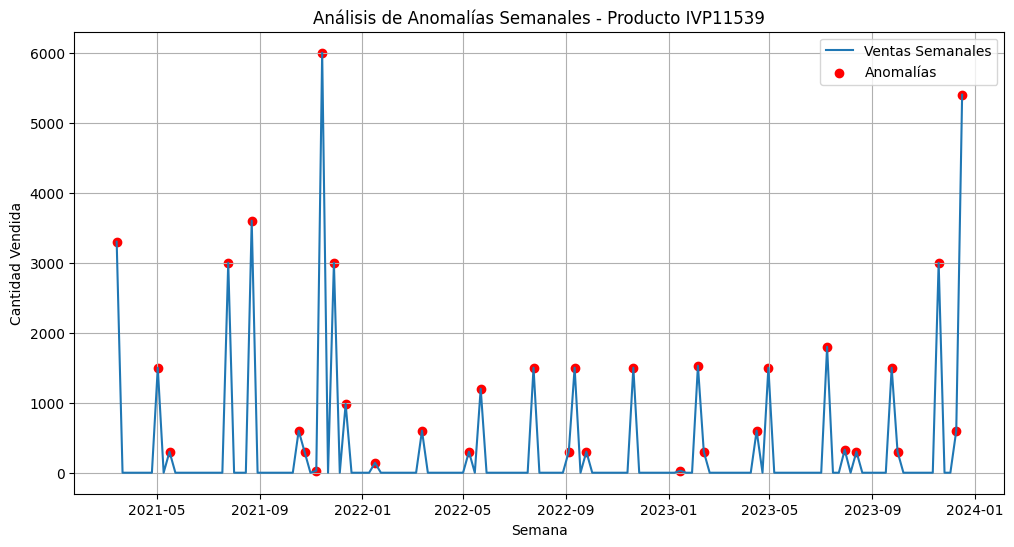

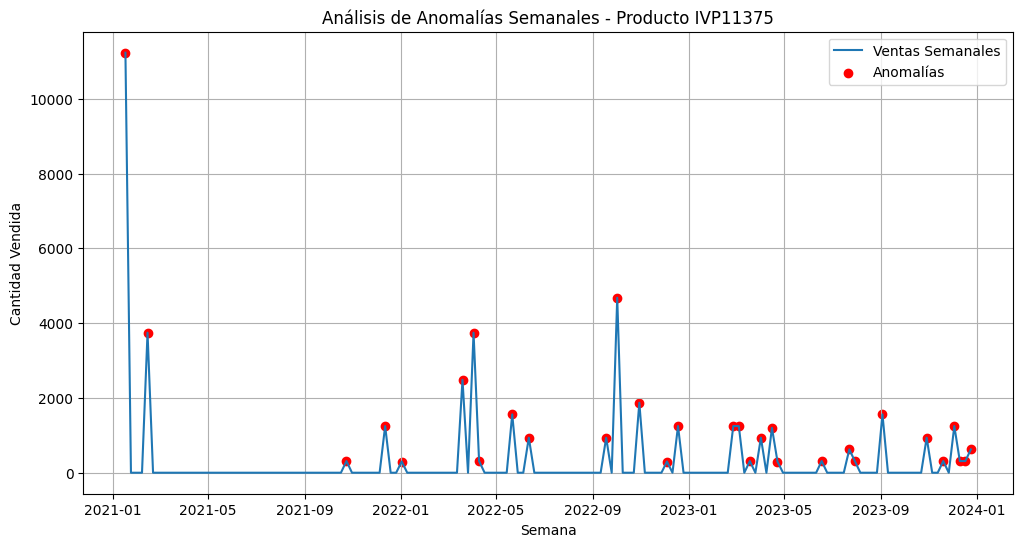

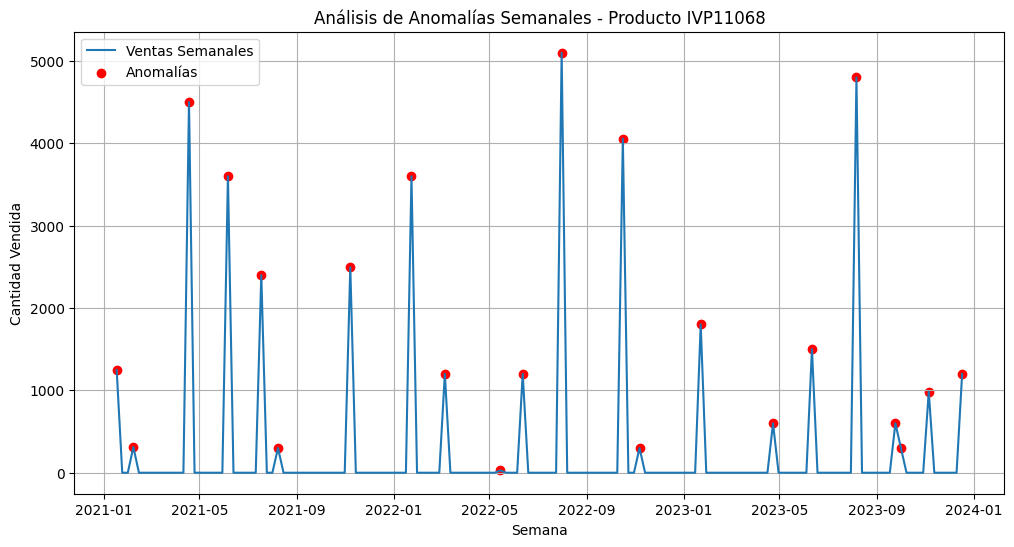

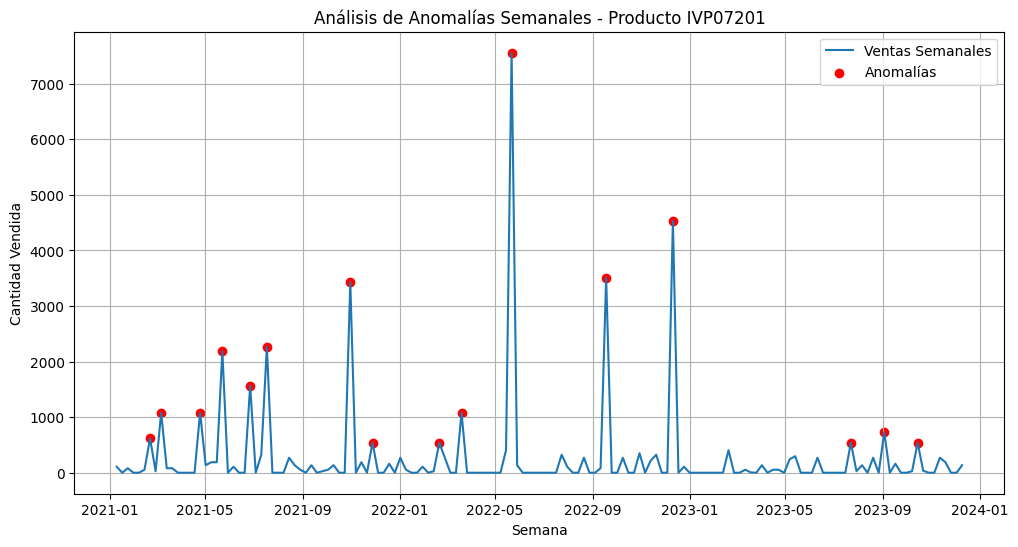

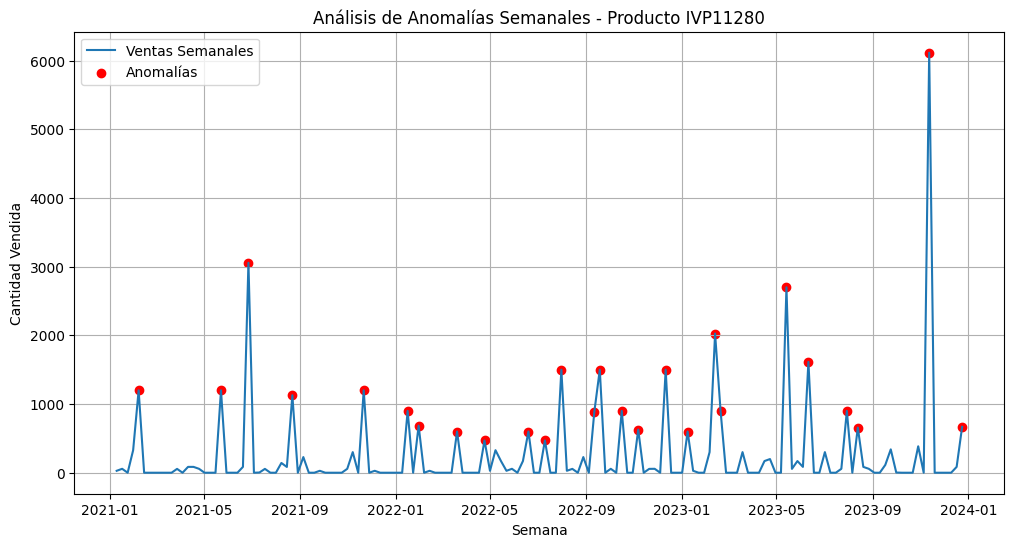

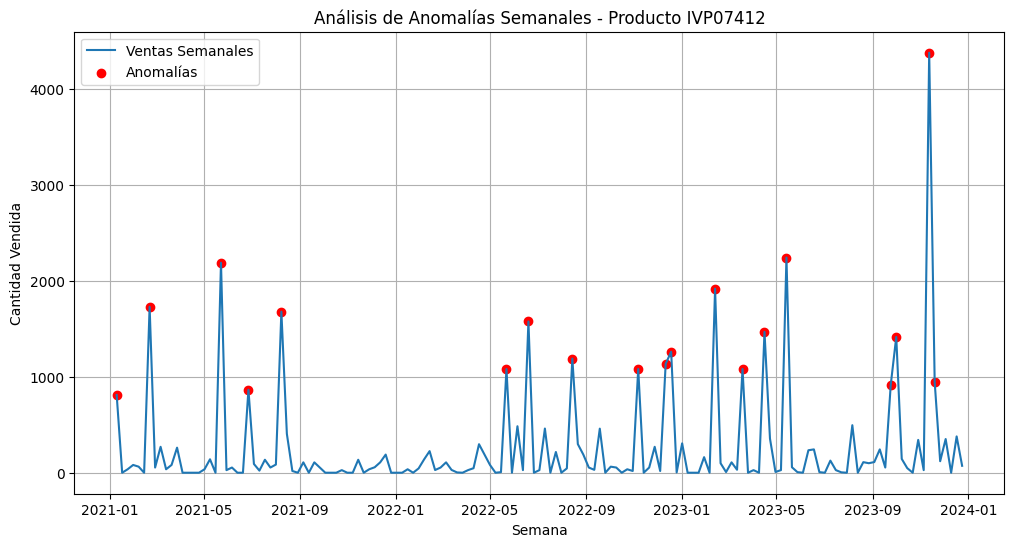

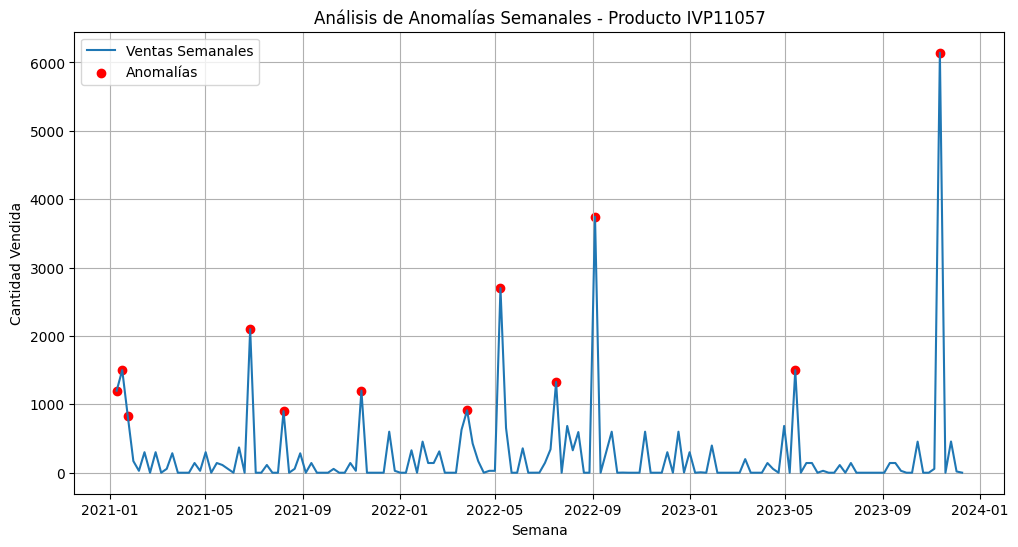

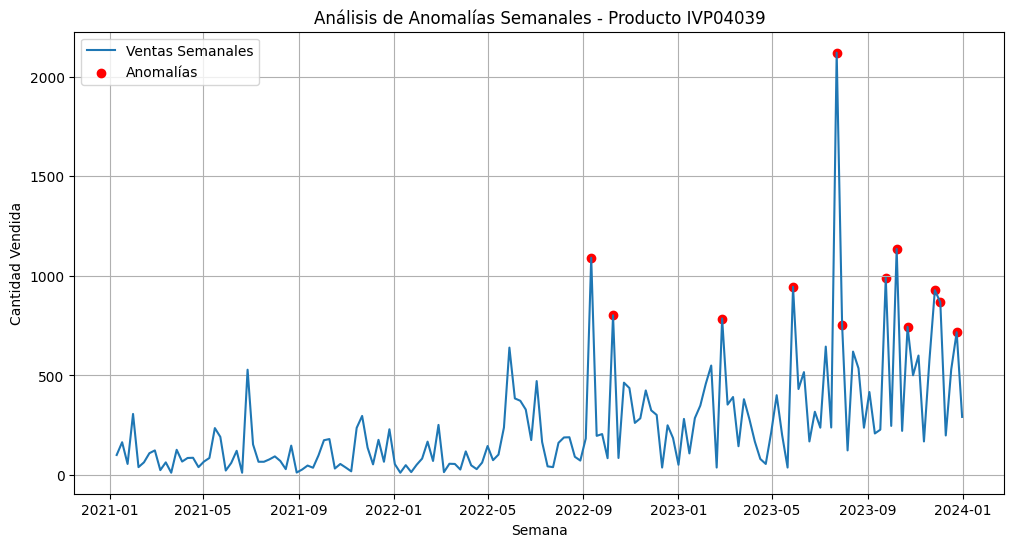

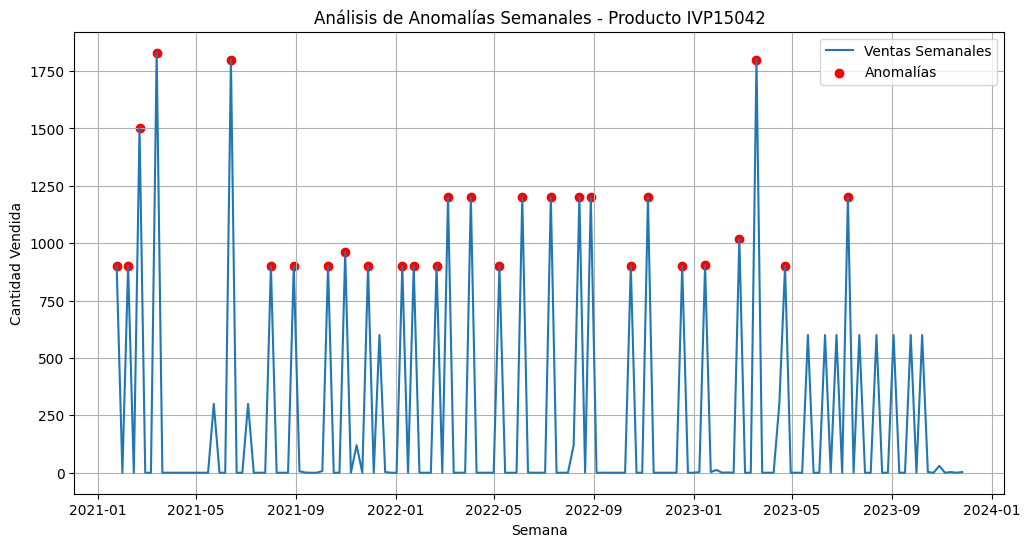

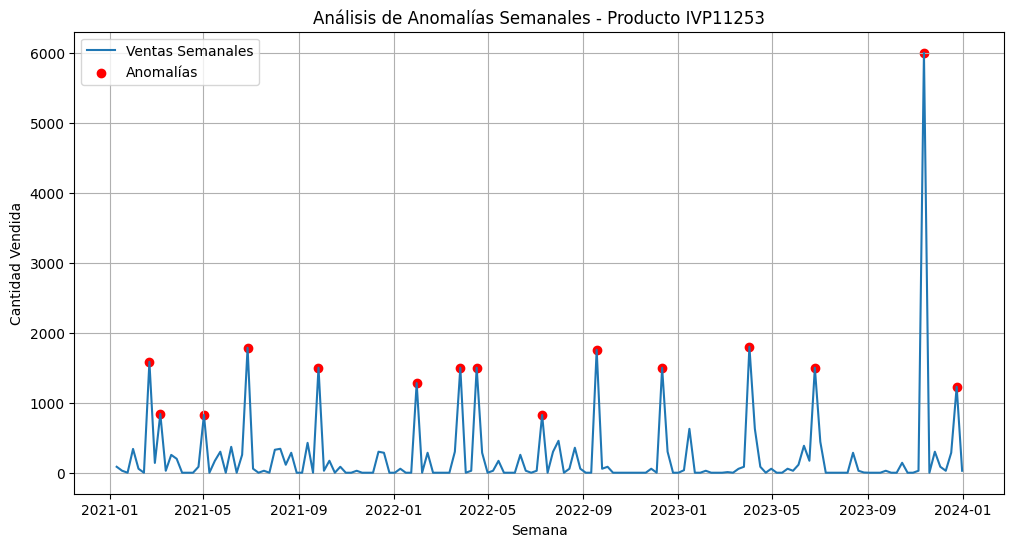

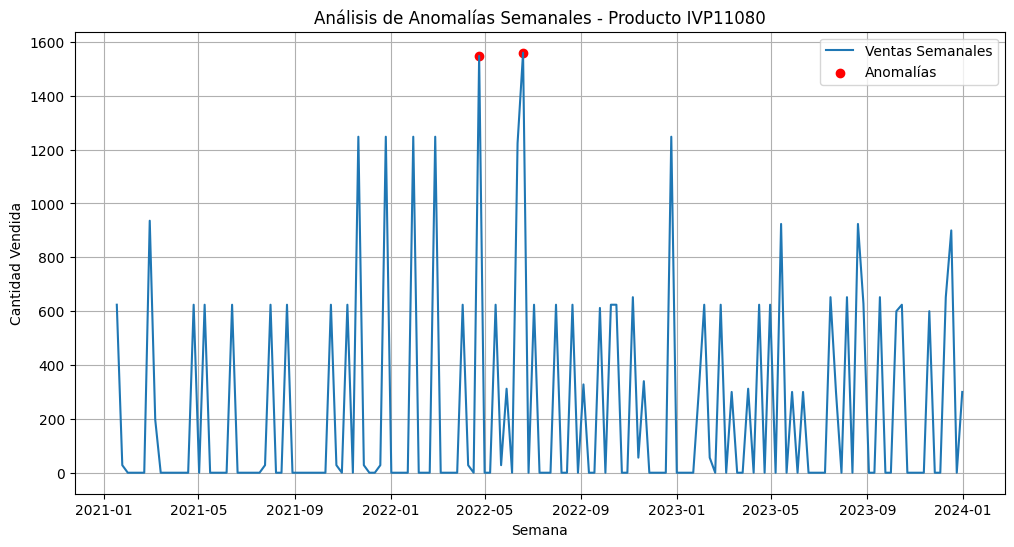

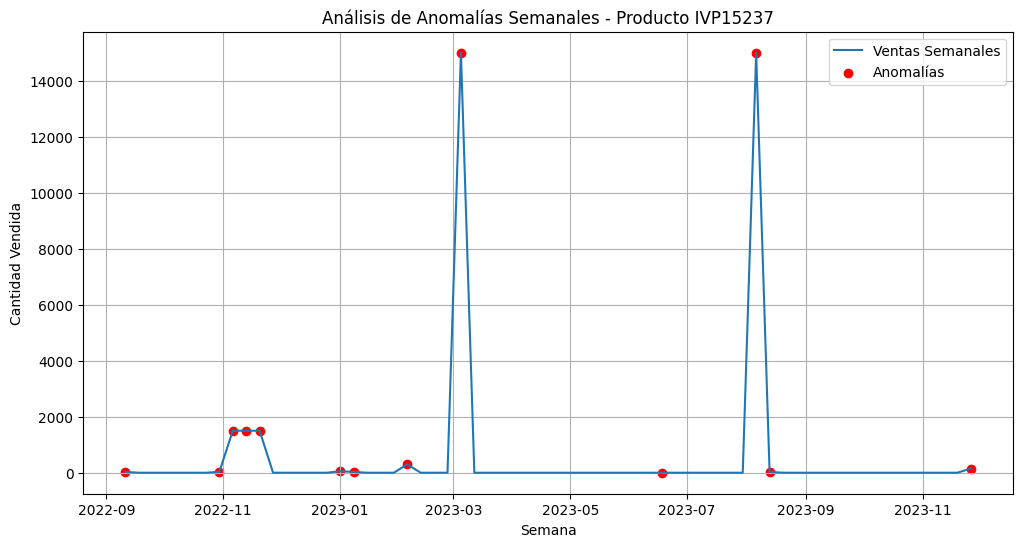

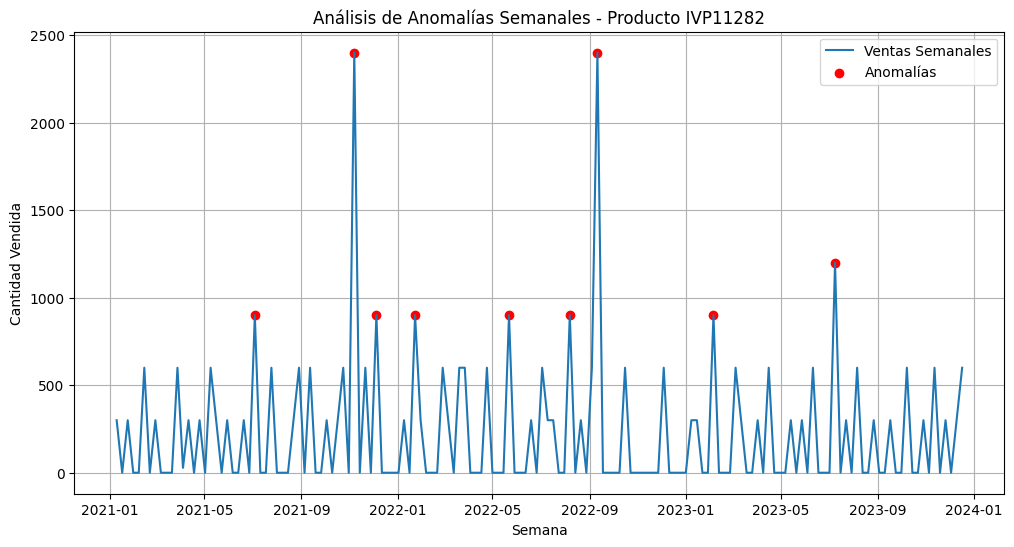

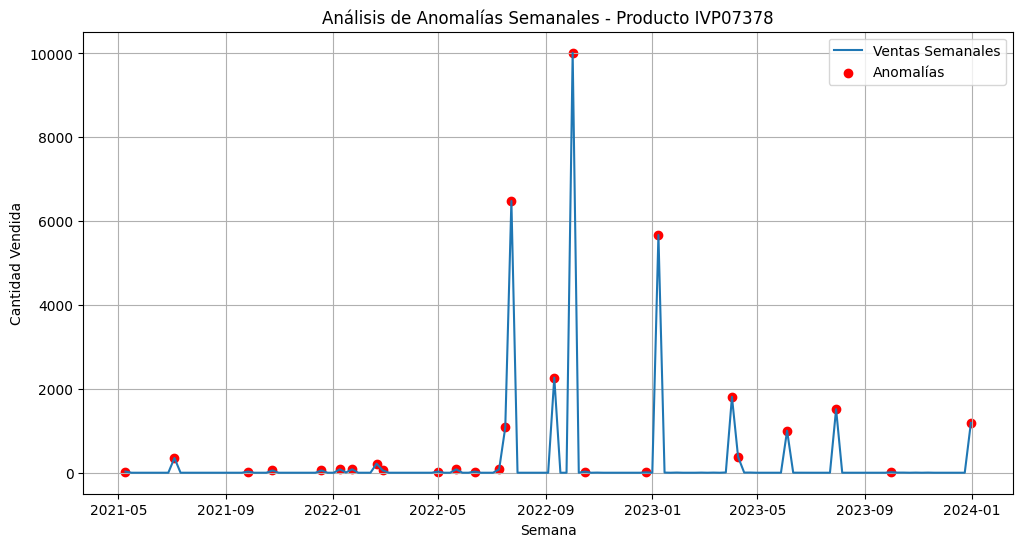

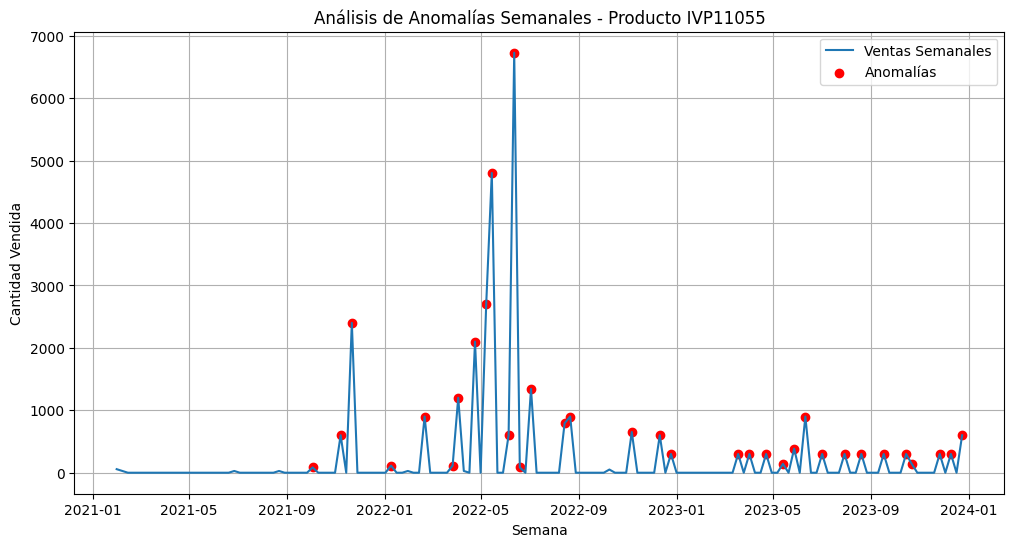

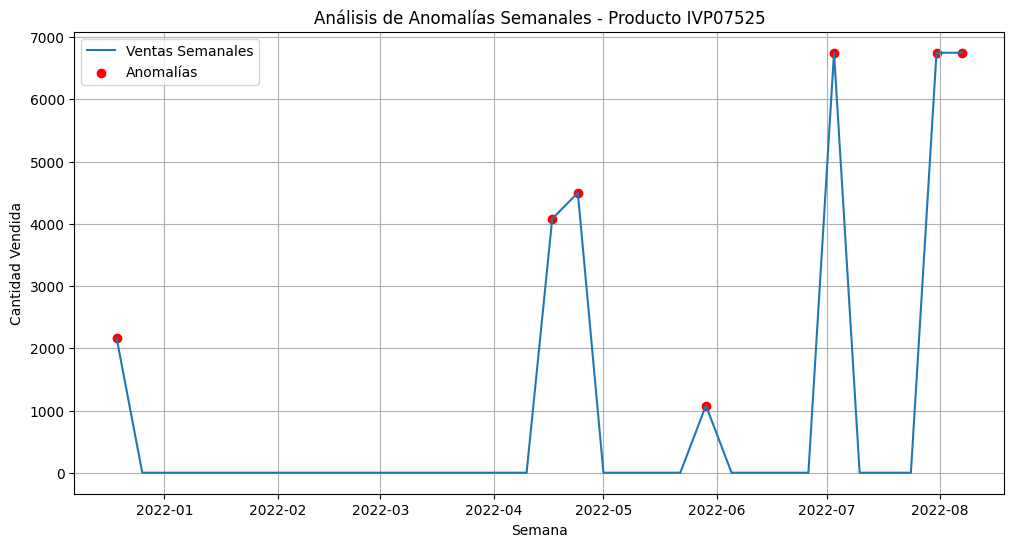

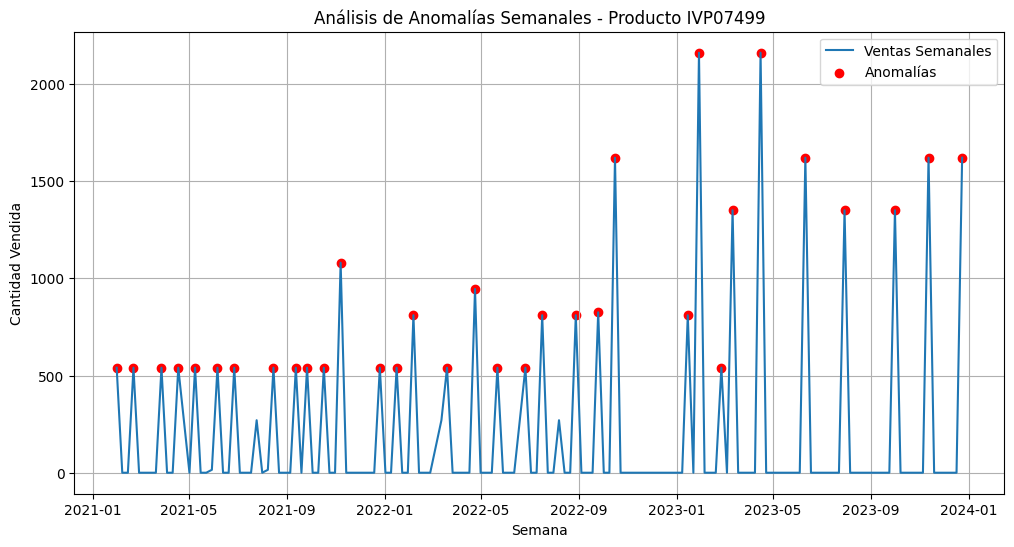

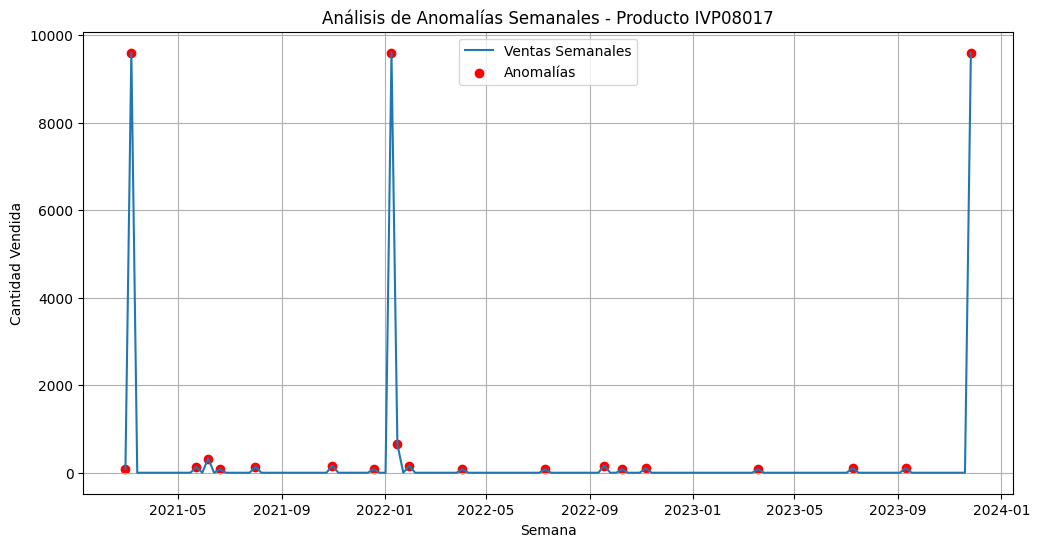

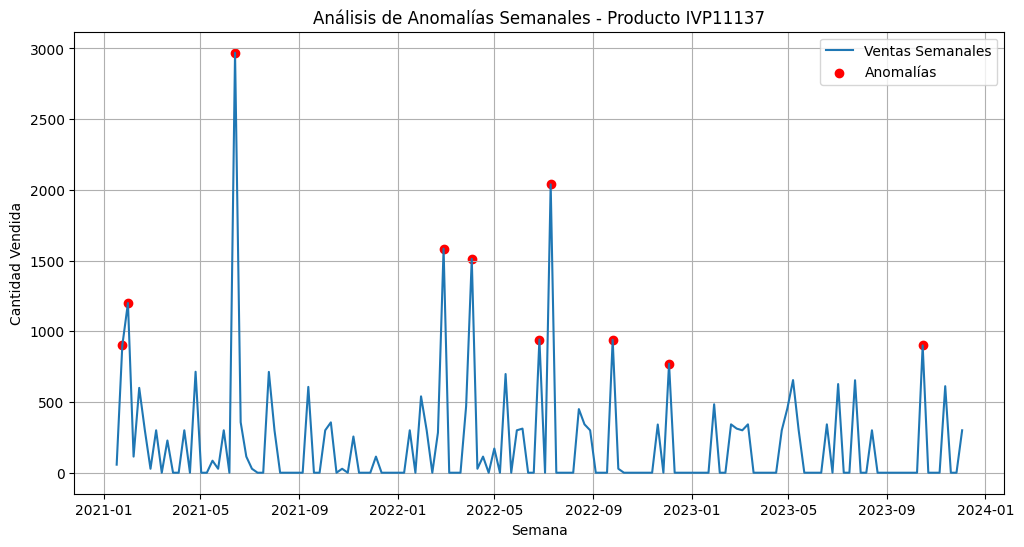

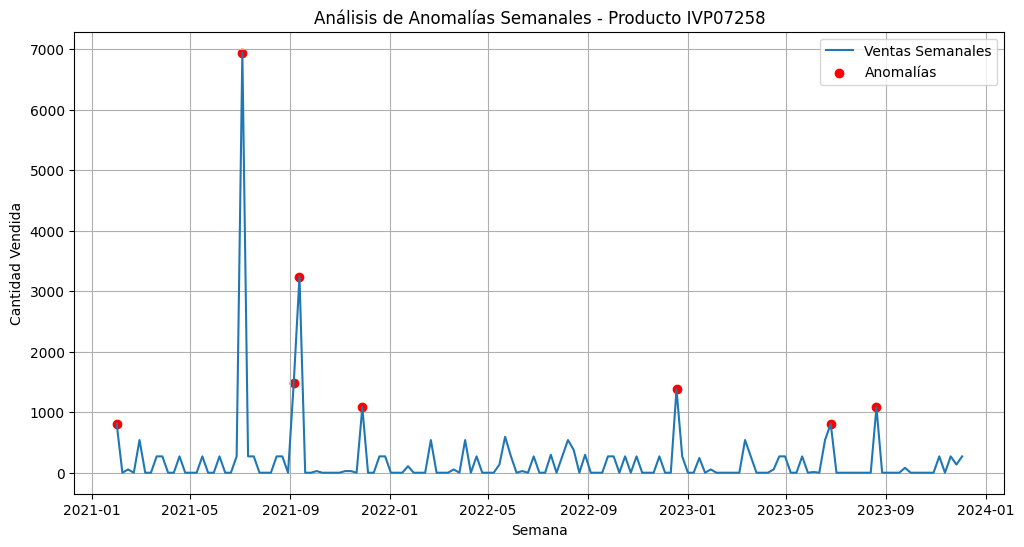

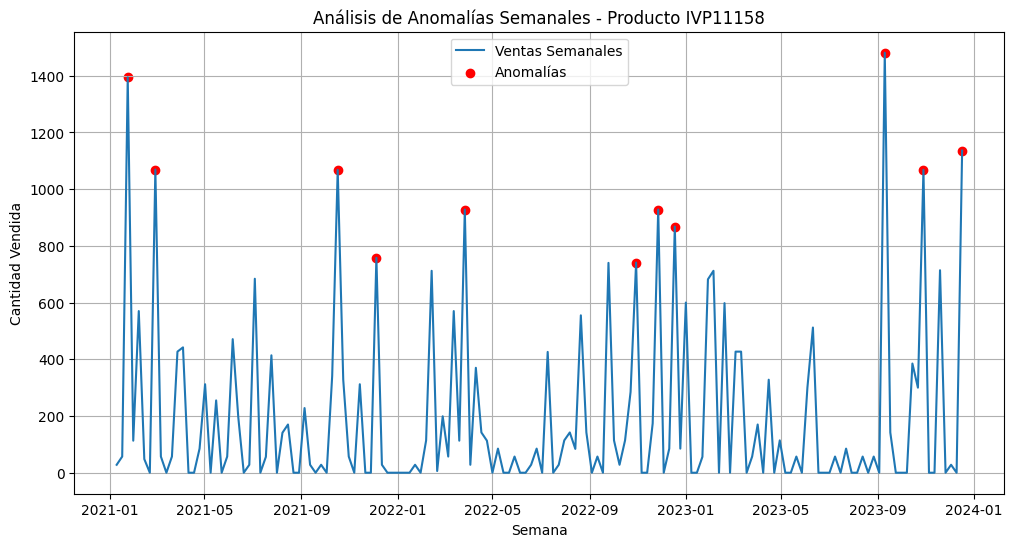

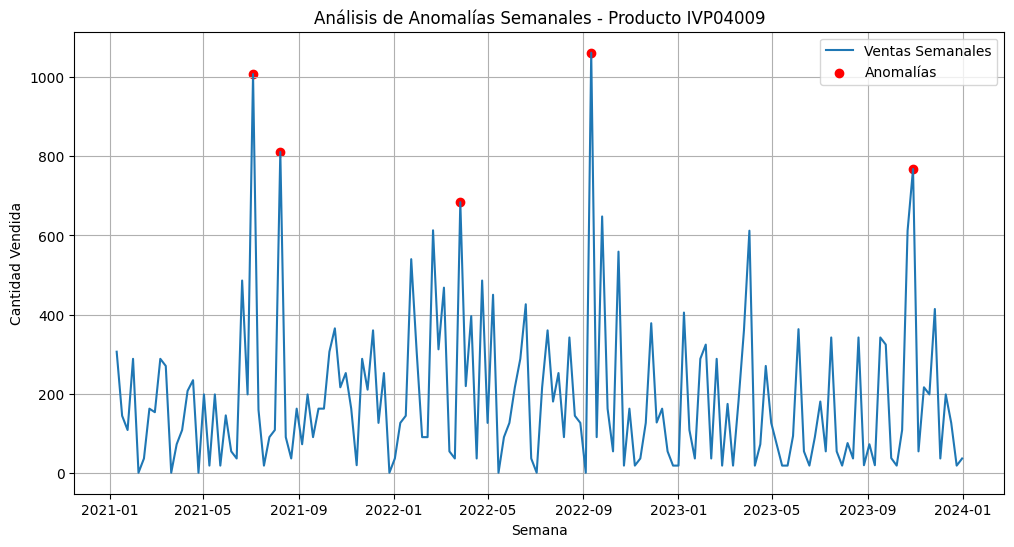

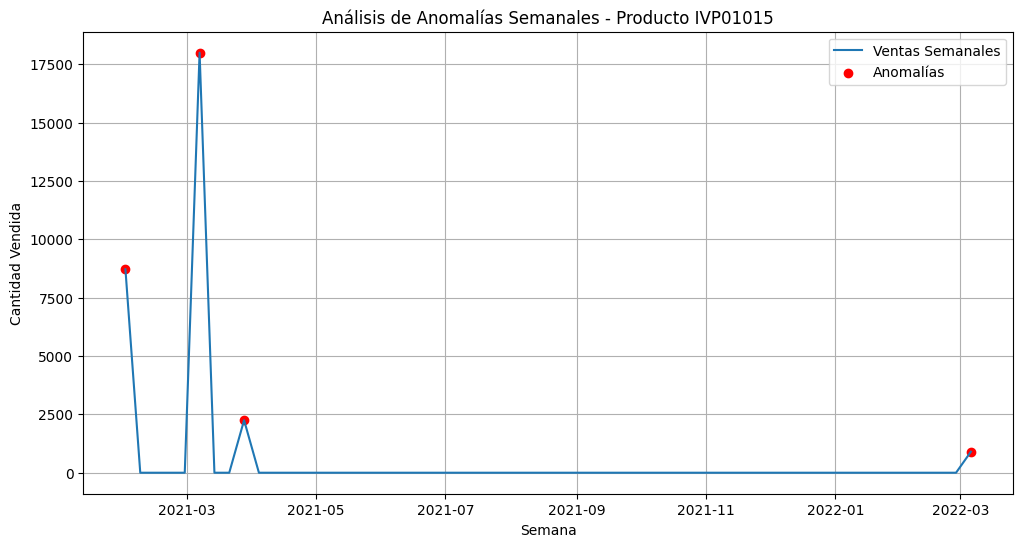

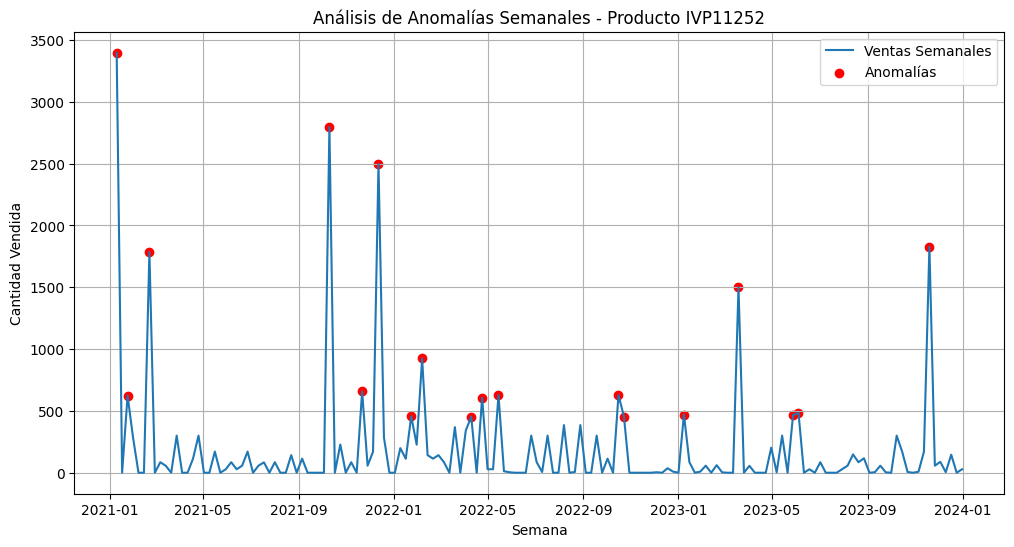

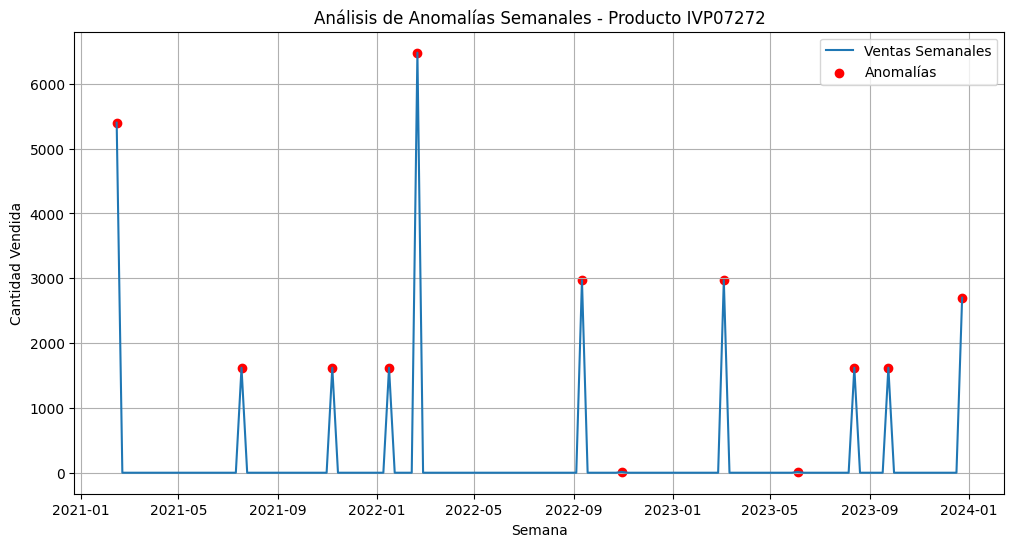

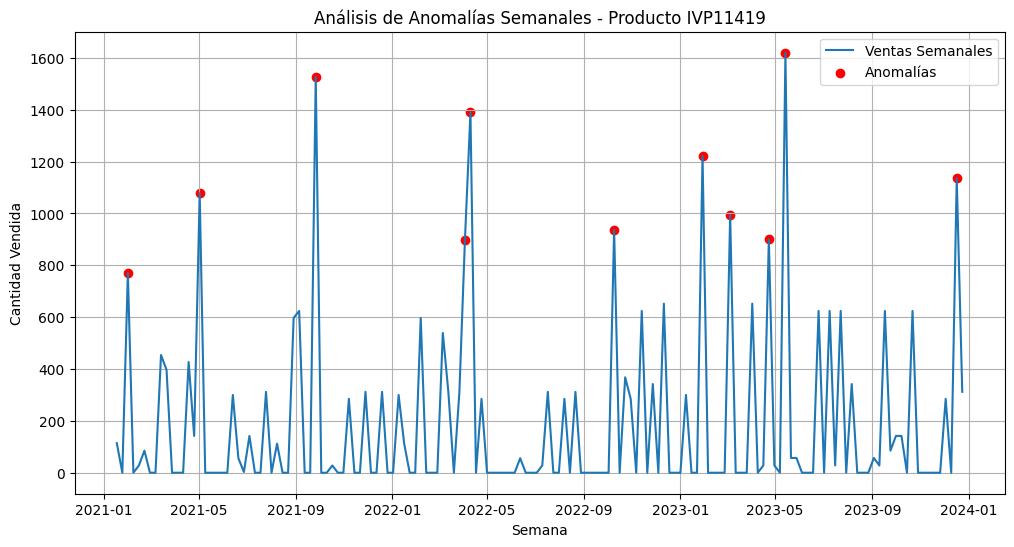

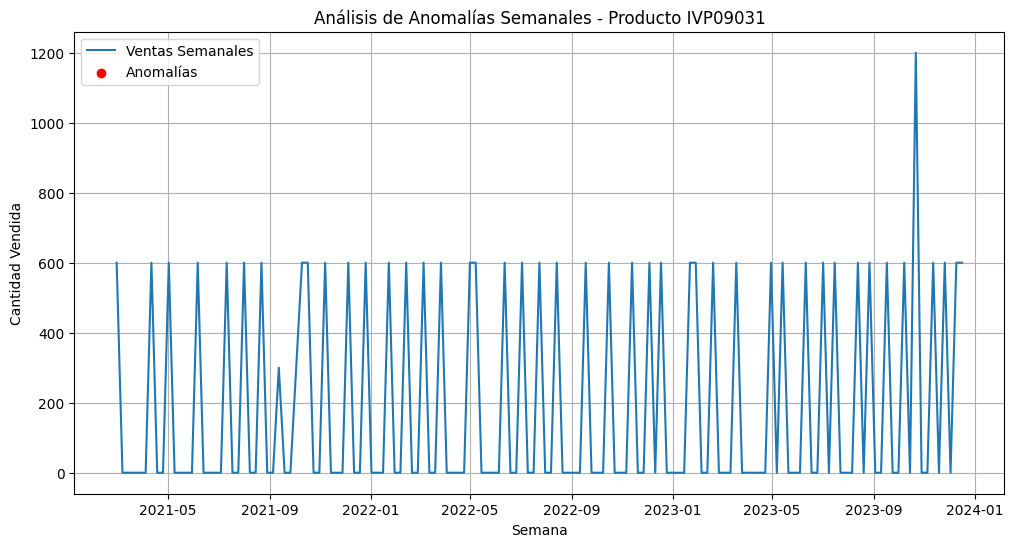

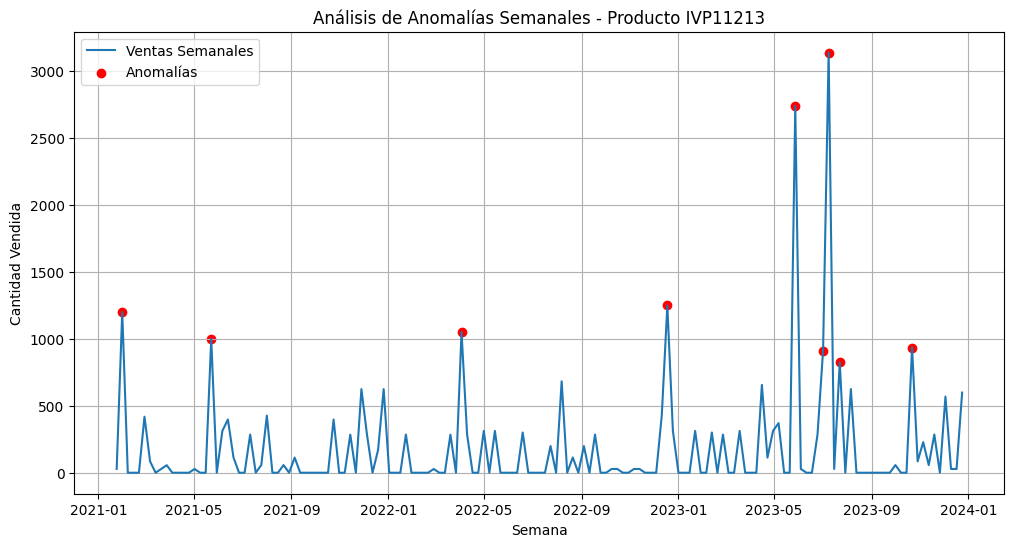

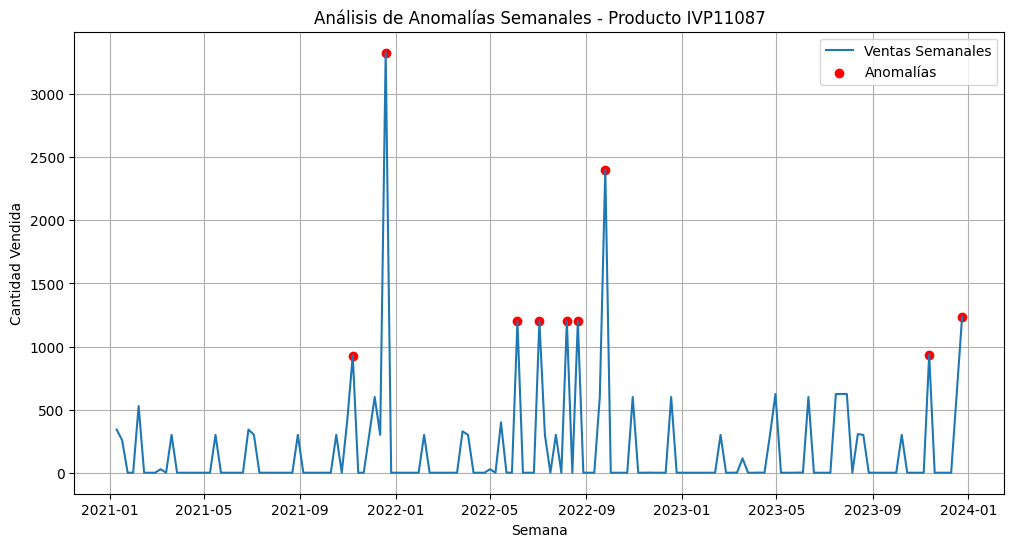

Producto  Semanas_Analizadas  Anomalías_Detectadas  Porcentaje_Anomalías
28  IVP11595                 155                    38                 24.52
39  IVP07436                 148                    36                 24.32
59  IVP11539                 145                    33                 22.76
49  IVP09076                 151                    34                 22.52
73  IVP11055                 152                    34                 22.37
..       ...                 ...                   ...                   ...
69  IVP11080                 155                     2                  1.29
34  IVP07445                 151                     1                  0.66
38  IVP11346                 155                     1                  0.65
52  IVP07410                 155                     1                  0.65
85  IVP09031                 147                     0                  0.00

[88 rows x 4 columns]

In [19]:
# Lista para almacenar los resultados de anomalías
anomalies_summary = []

# Analizamos las anomalías SEMANALES para cada producto
for producto in top_productos_semanal:
    data = ventas_semanal_producto[ventas_semanal_producto['Articulo'] == producto]

    # Serie temporal semanal completa
    serie = data.set_index('Fecha')['Cantidad'].resample('W').sum().fillna(0)

    # Calculamos IQR
    q1 = serie.quantile(0.25)
    q3 = serie.quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Detectamos anomalías
    anomalies = serie[(serie < lower_bound) | (serie > upper_bound)]

    # Guardamos resumen del producto
    anomalies_summary.append({
        'Producto': producto,
        'Semanas_Analizadas': len(serie),
        'Anomalías_Detectadas': len(anomalies),
        'Porcentaje_Anomalías': round(len(anomalies) / len(serie) * 100, 2)
    })

    # Gráfico por producto
    plt.figure(figsize=(12, 6))
    plt.plot(serie.index, serie.values, label='Ventas Semanales')
    plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalías')
    plt.title(f'Análisis de Anomalías Semanales - Producto {producto}')
    plt.xlabel('Semana')
    plt.ylabel('Cantidad Vendida')
    plt.legend()
    plt.grid(True)
    plt.show()

# Convertimos el resumen a DataFrame
df_anomalies_summary = pd.DataFrame(anomalies_summary)

# Mostramos el ranking de productos con más anomalías detectadas
df_anomalies_summary.sort_values(by='Porcentaje_Anomalías', ascending=False)

### Manual de Manejo de Anomalías en Productos (Método IQR) (Lee esto Sancho, antes del modelaje)
### Reglas de Decisión

1. **Si el producto tiene un porcentaje de anomalías mayor o igual al 20%**:
   - Se considera un producto con **alta inestabilidad**.
   - Se recomienda **suavizar** la serie temporal completa para reducir el impacto de valores atípicos.

2. **Si el producto tiene un porcentaje de anomalías menor al 20%**:
   - Se considera un producto **estable**.
   - Se recomienda **imputar únicamente las anomalías detectadas**, manteniendo el resto de la serie intacta.

### Método de Detección de Anomalías (IQR)

Los valores se consideran anómalos si se encuentran fuera de los límites establecidos por el rango intercuartílico (IQR).

- **Límite Inferior:** `Q1 - 1.5 * IQR`
- **Límite Superior:** `Q3 + 1.5 * IQR`


1. Suavizado (para productos con ≥ 20% de anomalías)

Para productos inestables, se recomienda aplicar una media móvil que suavice las variaciones extremas de la serie temporal.

In [22]:
# Suavizado con media móvil de 3 semanas
serie_suavizada = serie.rolling(window=3, center=True).mean()

# Rellenar los valores extremos iniciales/finales si es necesario
serie_suavizada = serie_suavizada.fillna(method='bfill').fillna(method='ffill')

C:\Users\danis\AppData\Local\Temp\ipykernel_10504\3729308860.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  serie_suavizada = serie_suavizada.fillna(method='bfill').fillna(method='ffill')


¿Cuándo usarlo?
Productos con alta inestabilidad (anomalías frecuentes).
Cuando se requiere disminuir la volatilidad antes de modelar o realizar predicciones.

2. Imputación de Anomalías (para productos con < 20% de anomalías)

Si el producto es estable, es suficiente con imputar las anomalías puntuales detectadas.

In [23]:
# Copia de la serie original
serie_imputada = serie.copy()

# Reemplazo de anomalías por NaN
serie_imputada[anomalies] = np.nan

# Interpolación para completar los valores faltantes
serie_imputada = serie_imputada.interpolate(method='linear')

# Rellenar si quedan valores nulos en los extremos
serie_imputada = serie_imputada.fillna(method='bfill').fillna(method='ffill')

C:\Users\danis\AppData\Local\Temp\ipykernel_10504\4195195814.py:5: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  serie_imputada[anomalies] = np.nan


IndexError: index 928 is out of bounds for axis 0 with size 155

¿Cuándo usarlo?
Productos mayormente estables.
Cuando las anomalías son eventos puntuales que no afectan la estructura general de la serie.

Recomendaciones Adicionales
Si un producto tiene más del 30% de anomalías, podría ser conveniente realizar un análisis más profundo o considerar modelos específicos para ese producto, incluyendo variables exógenas (clima, promociones, etc.).
Es recomendable documentar las fechas en que se presentan anomalías, especialmente si se conocen causas externas o eventos atípicos que las expliquen.
Los métodos de suavizado o imputación deben revisarse antes de alimentar cualquier modelo predictivo para evitar sesgos en los resultados.